In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

In [2]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py
%run ./Genetic_Lib.ipynb

5.3.1


In [67]:
path=(r"C:\Program Files\AMP Global (USA) MT5 Exchange-Traded Futures Only 2\terminal64.exe")
simbolo="DE40"
start_test = "2019-01-01"
end_test = "2023-05-01"
dataset=readdata_MT5_Date(simbolo,"H4",path,start_test,end_test)
dataset.tail()

,open,high,low,close,volume
time,,,,,
2023-02-17 04:00:00,15458.4,15459.9,15427.9,15427.9,1796
2023-02-17 08:00:00,15427.4,15453.2,15295.7,15402.8,9386
2023-02-17 12:00:00,15403.3,15444.7,15343.2,15440.7,9730
2023-02-17 16:00:00,15440.2,15517.7,15438.2,15482.4,10904
2023-02-17 20:00:00,15482.4,15531.9,15478.4,15526.9,5990


<AxesSubplot:title={'center':'DE40'}, xlabel='time'>

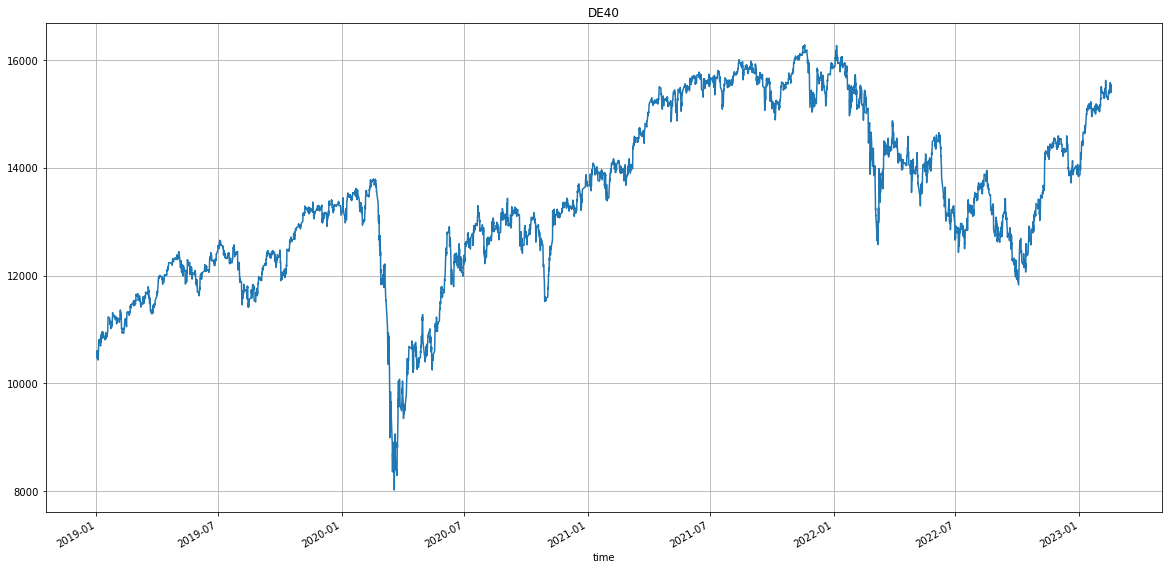

In [68]:
dataset.close.plot(figsize=(20,10),grid=True,title=simbolo)

In [64]:
period = 16
int(period*0.2) , int(period*0.65) , int(period*0.1)

(3, 10, 1)

In [78]:
from tqdm.notebook import tqdm
import talib as ta


def PF3up(df,cnt):
    df['MA3'] = ta.SMA(df['close'].values,3)
    df['MA10'] = ta.SMA(df['close'].values,10)
    df['310Fast'] = df['MA3'] - df['MA10']
    df['310Slow'] = ta.SMA(df['310Fast'].values,16)
    df['ROC'] = ta.ROC(df['close'].values,2)
    df['PF3up'] = [True if (roc > roc1 and F > F1 and S > S1)  else False for roc,roc1,F,F1,S,S1 in zip(df['ROC'],df['ROC'].shift(1),df['310Fast'],df['310Fast'].shift(1),df['310Slow'],df['310Slow'].shift(1))]
    df.drop('MA3',axis=1,inplace=True)
    df.drop('MA10',axis=1,inplace=True)
    df.drop('310Fast',axis=1,inplace=True)
    df.drop('310Slow',axis=1,inplace=True)
    df.drop('ROC',axis=1,inplace=True)
    
    return df['PF3up']

def PF3down(df,cnt):
    df['MA3'] = ta.SMA(df['close'].values,3)
    df['MA10'] = ta.SMA(df['close'].values,10)
    df['310Fast'] = df['MA3'] - df['MA10']
    df['310Slow'] = ta.SMA(df['310Fast'].values,16)
    df['ROC'] = ta.ROC(df['close'].values,2)
    df['PF3down'] = [True if (roc < roc1 and F < F1 and S < S1)  else False for roc,roc1,F,F1,S,S1 in zip(df['ROC'],df['ROC'].shift(1),df['310Fast'],df['310Fast'].shift(1),df['310Slow'],df['310Slow'].shift(1))]
    df.drop('MA3',axis=1,inplace=True)
    df.drop('MA10',axis=1,inplace=True)
    df.drop('310Fast',axis=1,inplace=True)
    df.drop('310Slow',axis=1,inplace=True)
    df.drop('ROC',axis=1,inplace=True)

    return df['PF3down']


def MACD(dataset,period,direzione):
    macd, macd_signal, macd_hist = ta.MACD(dataset["close"], fastperiod=period, slowperiod=int(period*2.2), signalperiod=int(period*0.8))
    macd_signal = ta.WMA(macd,period)
    macd_signal = ta.SMA(macd,period)
    if direzione == 1:
        return  (macd-macd_signal)<0
    if direzione == -1:
        return  (macd-macd_signal)>0
    
def STOCH(dataset,period,direzione):
    slowk , slowd = ta.STOCH(dataset["high"], dataset["low"], dataset["close"], period, int(period*0.3), 0, int(period*0.25), 0)
    if direzione == 1:
        return  slowk>slowd
    if direzione == -1:
        return  slowk<slowd
    
def RSI_ctr(dataset,period,level,direzione):
    rsi = ta.RSI(dataset["close"],period)
    if direzione == 1:
        return  (rsi.shift(1)<(50+level))&(rsi>(50+level))
    if direzione == -1:
        return  (rsi.shift(1)>(50-level))&(rsi<(50-level))

def RSI_tr(dataset,period,level,direzione):
    rsi = ta.RSI(dataset["close"],period)
    if direzione == 1:
        return  (rsi.shift(1)<(50-level))&(rsi>(50-level))
    if direzione == -1:
        return  (rsi.shift(1)>(50+level))&(rsi<(50+level))
    
def hour_condition(dataset,hour,cnt):
    return dataset.index.hour==hour
  
    
def dayofweek_condition(dataset,dayofweek,cnt):
    return dataset.index.dayofweek==dayofweek

def day_condition(dataset,day,cnt):
    return dataset.index.day==day
  
    
def month_condition(dataset,month,cnt):
    return dataset.index.month==month


    
def apply_indicator(history):
    
    dow_list=[]
    for e in range(0,5):
        for i in range(11): ### numero di ripetizioni
            dow_list.append(eval('"(dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            dow_list.append(eval('"(~dayofweek_condition(dataset,"+str(e)+","+str(i)+"))"'))
        
    hor_list=[]
    for e in range(0,24,4): 
        for i in range(11): ### numero di ripetizioni
            hor_list.append(eval('"(hour_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            hor_list.append(eval('"(~hour_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            
            
    day_list=[]
    for e in range(1,32):
        for i in range(5): ### numero di ripetizioni
            day_list.append(eval('"(day_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            day_list.append(eval('"(~day_condition(dataset,"+str(e)+","+str(i)+"))"'))
        
    month_list=[]
    for e in range(1,13):
        for i in range(6): ### numero di ripetizioni
            month_list.append(eval('"(month_condition(dataset,"+str(e)+","+str(i)+"))"')) 
            month_list.append(eval('"(~month_condition(dataset,"+str(e)+","+str(i)+"))"'))         
            
            
        
    macd_list=[]
    for e in range(3,51):
        macd_list.append(eval('"(MACD(dataset,"+str(e)+",1))"'))   
        macd_list.append(eval('"(MACD(dataset,"+str(e)+",-1))"'))  
            
    stoch_list=[]
    for e in range(6,51):
        stoch_list.append(eval('"(STOCH(dataset,"+str(e)+",1))"'))   
        stoch_list.append(eval('"(STOCH(dataset,"+str(e)+",-1))"'))  
        
    rsi_list = []
    for e in range(5,30): ## periodi 
        for i in range(5,45,5): ##livelli
            rsi_list.append(eval('"(RSI_ctr(dataset,"+str(e)+","+str(i)+",1))"'))   
            rsi_list.append(eval('"(RSI_ctr(dataset,"+str(e)+","+str(i)+",-1))"'))
            rsi_list.append(eval('"(RSI_tr(dataset,"+str(e)+","+str(i)+",1))"'))   
            rsi_list.append(eval('"(RSI_tr(dataset,"+str(e)+","+str(i)+",-1))"'))
            
    pf3_list=[]
    for i in range(11):
        pf3_list.append(eval('"(PF3up(dataset,"+str(i)+"))"')) 
        pf3_list.append(eval('"(PF3down(dataset,"+str(i)+"))"')) 
        
        
    lista_rules=[]
    lista_indicatori=[macd_list,stoch_list,dow_list,hor_list,day_list,month_list] #macd_list,stoch_list,rsi_list ,stoch_listmacd_list
    
    tmp_df = dataset.close.to_frame()
    
    for i in tqdm(lista_indicatori):
        print(len(i))
        for e in i:
            tmp_check=eval(e)
            if (tmp_check.sum()>10)&(tmp_check.sum()<len(tmp_check)):
                tmp_df[e]=tmp_check
    tmp_df.drop(["close"],axis=1,inplace=True)
    return  tmp_df , tmp_df.columns.to_list() 


In [79]:
%time rules, rule_formulas = apply_indicator(dataset)
print(len(rule_formulas))

  0%|          | 0/6 [00:00<?, ?it/s]

96
90
110
132
310
144
Wall time: 696 ms
878


In [80]:
%run ./Genetic_Lib.ipynb

In [81]:
def all_gains(dna):
    
    rule = setups(numba.typed.List(dna))
    rule.setflags(write=1)
    rule=rule[:Out_Of_Sample_pct]
    gains = numba_engine(rule,TIME_EXIT,gains_array,COSTS_FIXED)
    tmp_times_array = times_array
    ls=[]
    for e in range(len(gains)):
        if gains[e]!=0:
            ls.append([tmp_times_array[e],gains[e]])
    if INSTABILITY_FACTOR>0:
        ls = instability(ls,INSTABILITY_FACTOR)
    return ls

def OOS(dataset,pct):
    if pct == 0:
        return len(dataset)
    else:
        return int(len(dataset) - (len(dataset) // (100/pct)))
    
def instability(array,pct):
    dimension = int(len(array) - (len(array) // (100/pct)))
    rng = np.random.default_rng()
    rand_array=rng.choice(array, dimension)
    return np.array(sorted(sorted(rand_array,key=lambda e:e[1]),key=lambda e:e[0]))

In [95]:
secondary_equity = all_gains(last_dna)

In [82]:
secondary_equity = []

('generation', 14, ':', 0.32, ' ', '((~month_condition(dataset,6,3))) & ((MACD(dataset,49,-1))) & ((dayofweek_condition(dataset,1,10)))')


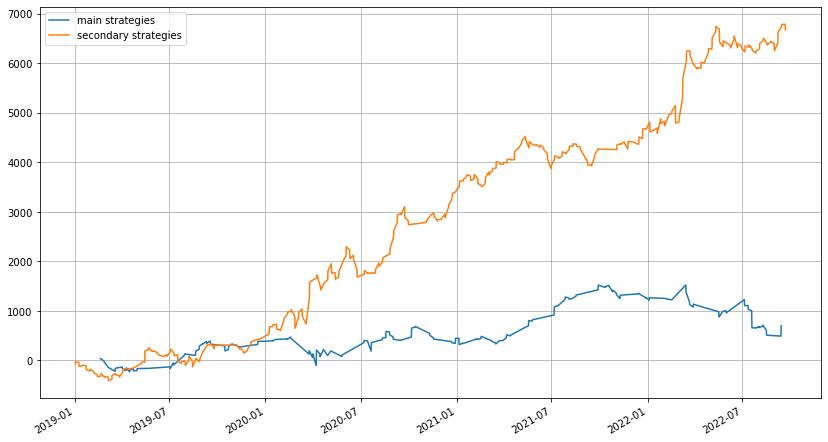

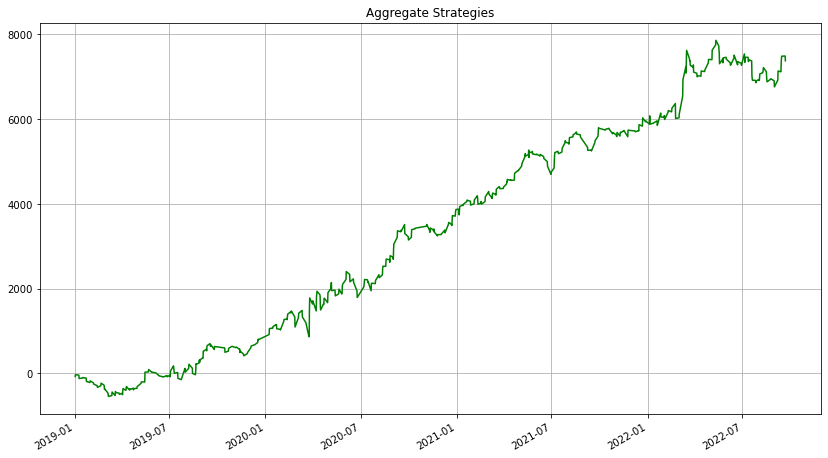

Wall time: 16 s


In [97]:
INSTRUMENT = 2  # 1: equity, 2: future, 3: crypto/forex
CAPITAL = 1  # money per trade (case INSTRUMENTS = 1,3) or number of contracts (case INSTRUMENTS = 2)
BIGPOINTVALUE = get_poin_values(path,simbolo)
TICK = 0.0001
COSTS_FIXED = 0
Out_Of_Sample_pct = OOS(dataset,10)
secondary_equity = check_secondary_equity(secondary_equity)

TIME_EXIT = 2
DIRECTION = "short"

POPULATION_SIZE = 150
NUM_GENERATIONS = 15

DNA_SIZE = 3
BEST_DNA_RATIO = 0.2
CROSS_DNA_RATIO = 0.2
MUTATION_PROB = 0.1

# Profit
# AvgTrade
# ProfitFactor
# GrossProfit
# Profit/MaxDrawDown
# AvgTrade/MaxDrawDown
# KestnerRatio
# StandardDeviation
# SQN
FITNESS_FUNCTION = "KestnerRatio"
MIN_OPERATIONS = 90

INSTABILITY_FACTOR = 0

# Conversioni per Numba
rules_array = rules.iloc[:Out_Of_Sample_pct].copy().values.T
open_array = dataset.open.values[:Out_Of_Sample_pct].copy()
close_array = dataset.close.values[:Out_Of_Sample_pct].copy()
times_array = dataset.index.values[:Out_Of_Sample_pct].copy()
gains_array = target(DIRECTION,TIME_EXIT,dataset.iloc[:Out_Of_Sample_pct]) 

population = first_generation()

OOS_date = dataset.iloc[:Out_Of_Sample_pct].index[-1]

%time best_dnas = evolution()

<AxesSubplot:title={'center':'Log - evolution of metrics  '}>

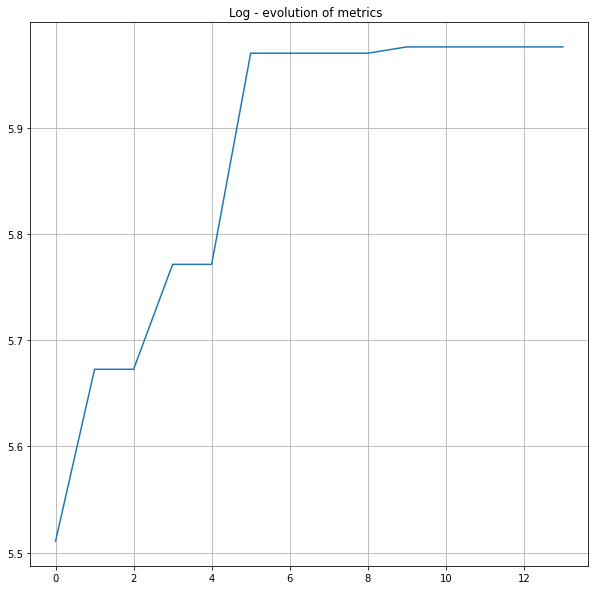

In [9]:
log_metric = pd.Series(log)
log_metric.plot(grid=True,figsize=(10,10),title="Log - evolution of metrics  ")

In [10]:
df_operations = pd.DataFrame()
#INSTABILITY_FACTOR =0
for e in range(len(best_dnas)):
    x=all_gains(best_dnas[e])
    times, gains = zip(*x)
    y=pd.Series(index=times,data=gains)
    y=y.to_frame()
    y.columns=(["Generazione_"+str(e)])
    y=y.resample("D").sum()
    df_operations=pd.concat([df_operations,y],axis=1).fillna(0)


<AxesSubplot:>

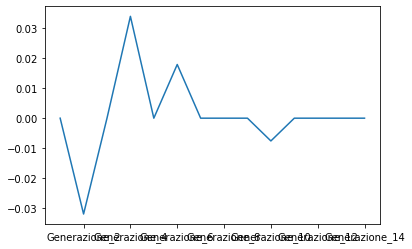

In [11]:
a=df_operations.corr().iloc[:,0]
b=a[a!=a.shift(1)].index.to_list()
df_operations.corr().sum().pct_change().plot()

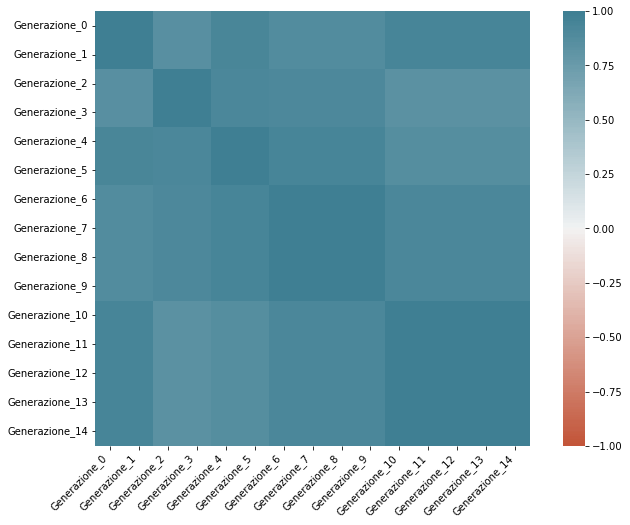

In [12]:
import matplotlib.pyplot as plt

corr=df_operations.corr()

import seaborn as sns
%matplotlib inline
plt.figure(figsize=[12,8])
# plot the heatmap
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [13]:
df_operations[b].resample("D").sum().corr()

,Generazione_0,Generazione_2,Generazione_4,Generazione_6,Generazione_10
Generazione_0,1.000000,0.857253,0.932818,0.880505,0.938189
Generazione_2,0.857253,1.000000,0.919031,0.907366,0.833971
Generazione_4,0.932818,0.919031,1.000000,0.943973,0.865243
Generazione_6,0.880505,0.907366,0.943973,1.000000,0.917905
Generazione_10,0.938189,0.833971,0.865243,0.917905,1.000000


<AxesSubplot:>

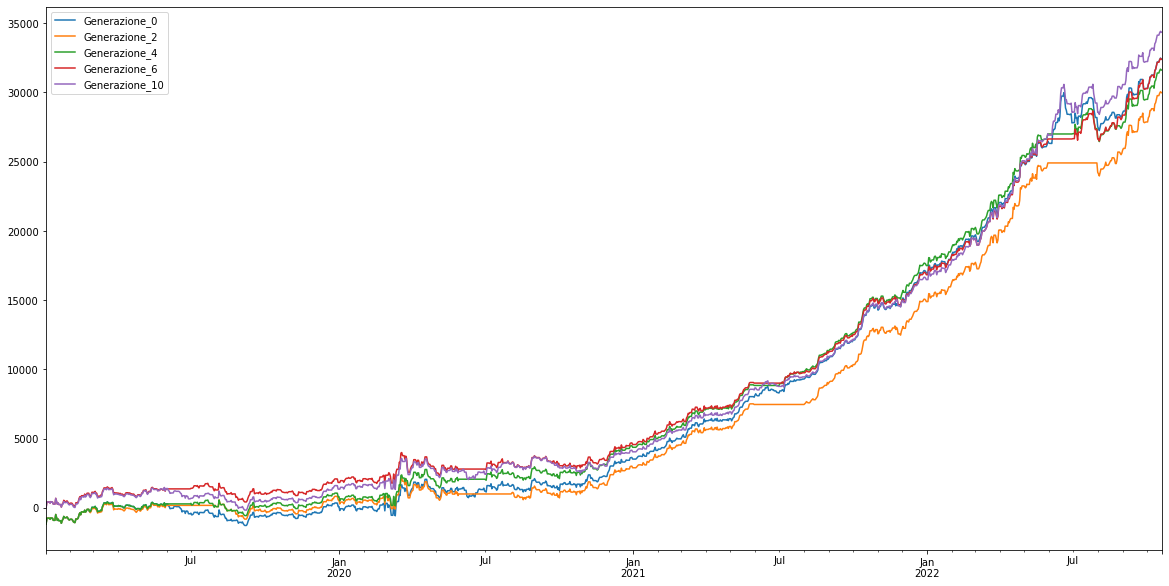

In [30]:
df_operations[b].cumsum().plot(figsize=(20,10))

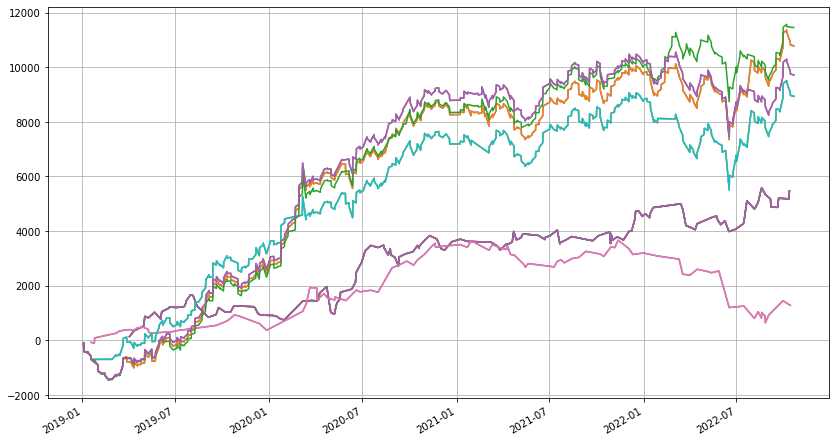

In [31]:
for el in best_dnas:
    plot_equity(el)

In [88]:
# stampa la fitness del miglior DNA dell'ultima generazione
last_dna = best_dnas[-1]
fitness(last_dna)

3.4832736852006265

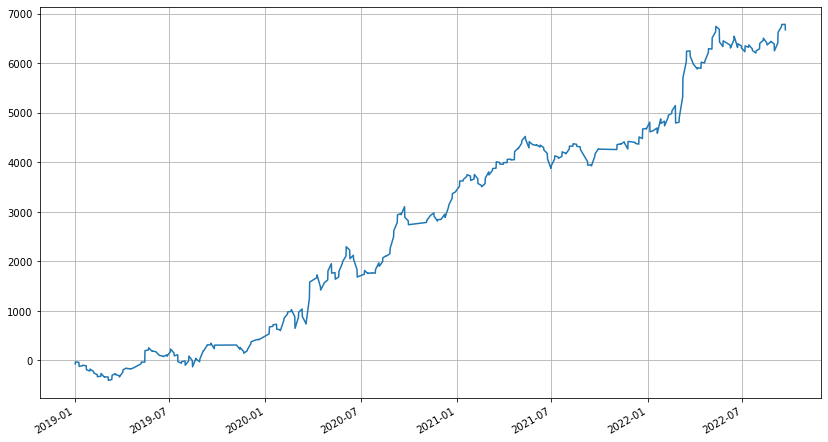

In [89]:
plot_equity(last_dna)


Elaboration starting at: 2023-03-27 15:10:58.652089
Elaboration completed at: 2023-03-27 15:10:58.655092 in 0:00:00.003003

Consistency check: entries: 380 exits: 380

*****************************************************************************************
*** Performance Report - by Gandalf Project R&D - Version Wintermute - Copyright 2022 ***
*****************************************************************************************

CAGR:                     1.34 (capital = 100000)
Annual Return:            1.38 (capital = 100000)

Calmar Ratio:             2.7 (yearly)
Sharpe Ratio:             1.27 (initial capital = 100000, risk free rate = 0.0)
Sortino Ratio:            0.54 (initial capital = 100000, risk free rate = 0.0)
Omega Ratio:              0.13 (threshold = 100)
Kestner Ratio:            0.88

Operations:               380

Profit:                   6905.72
Average Trade:            18.17

Profit Factor:            1.65
Gross Profit:             17594.11
Gross Loss:    

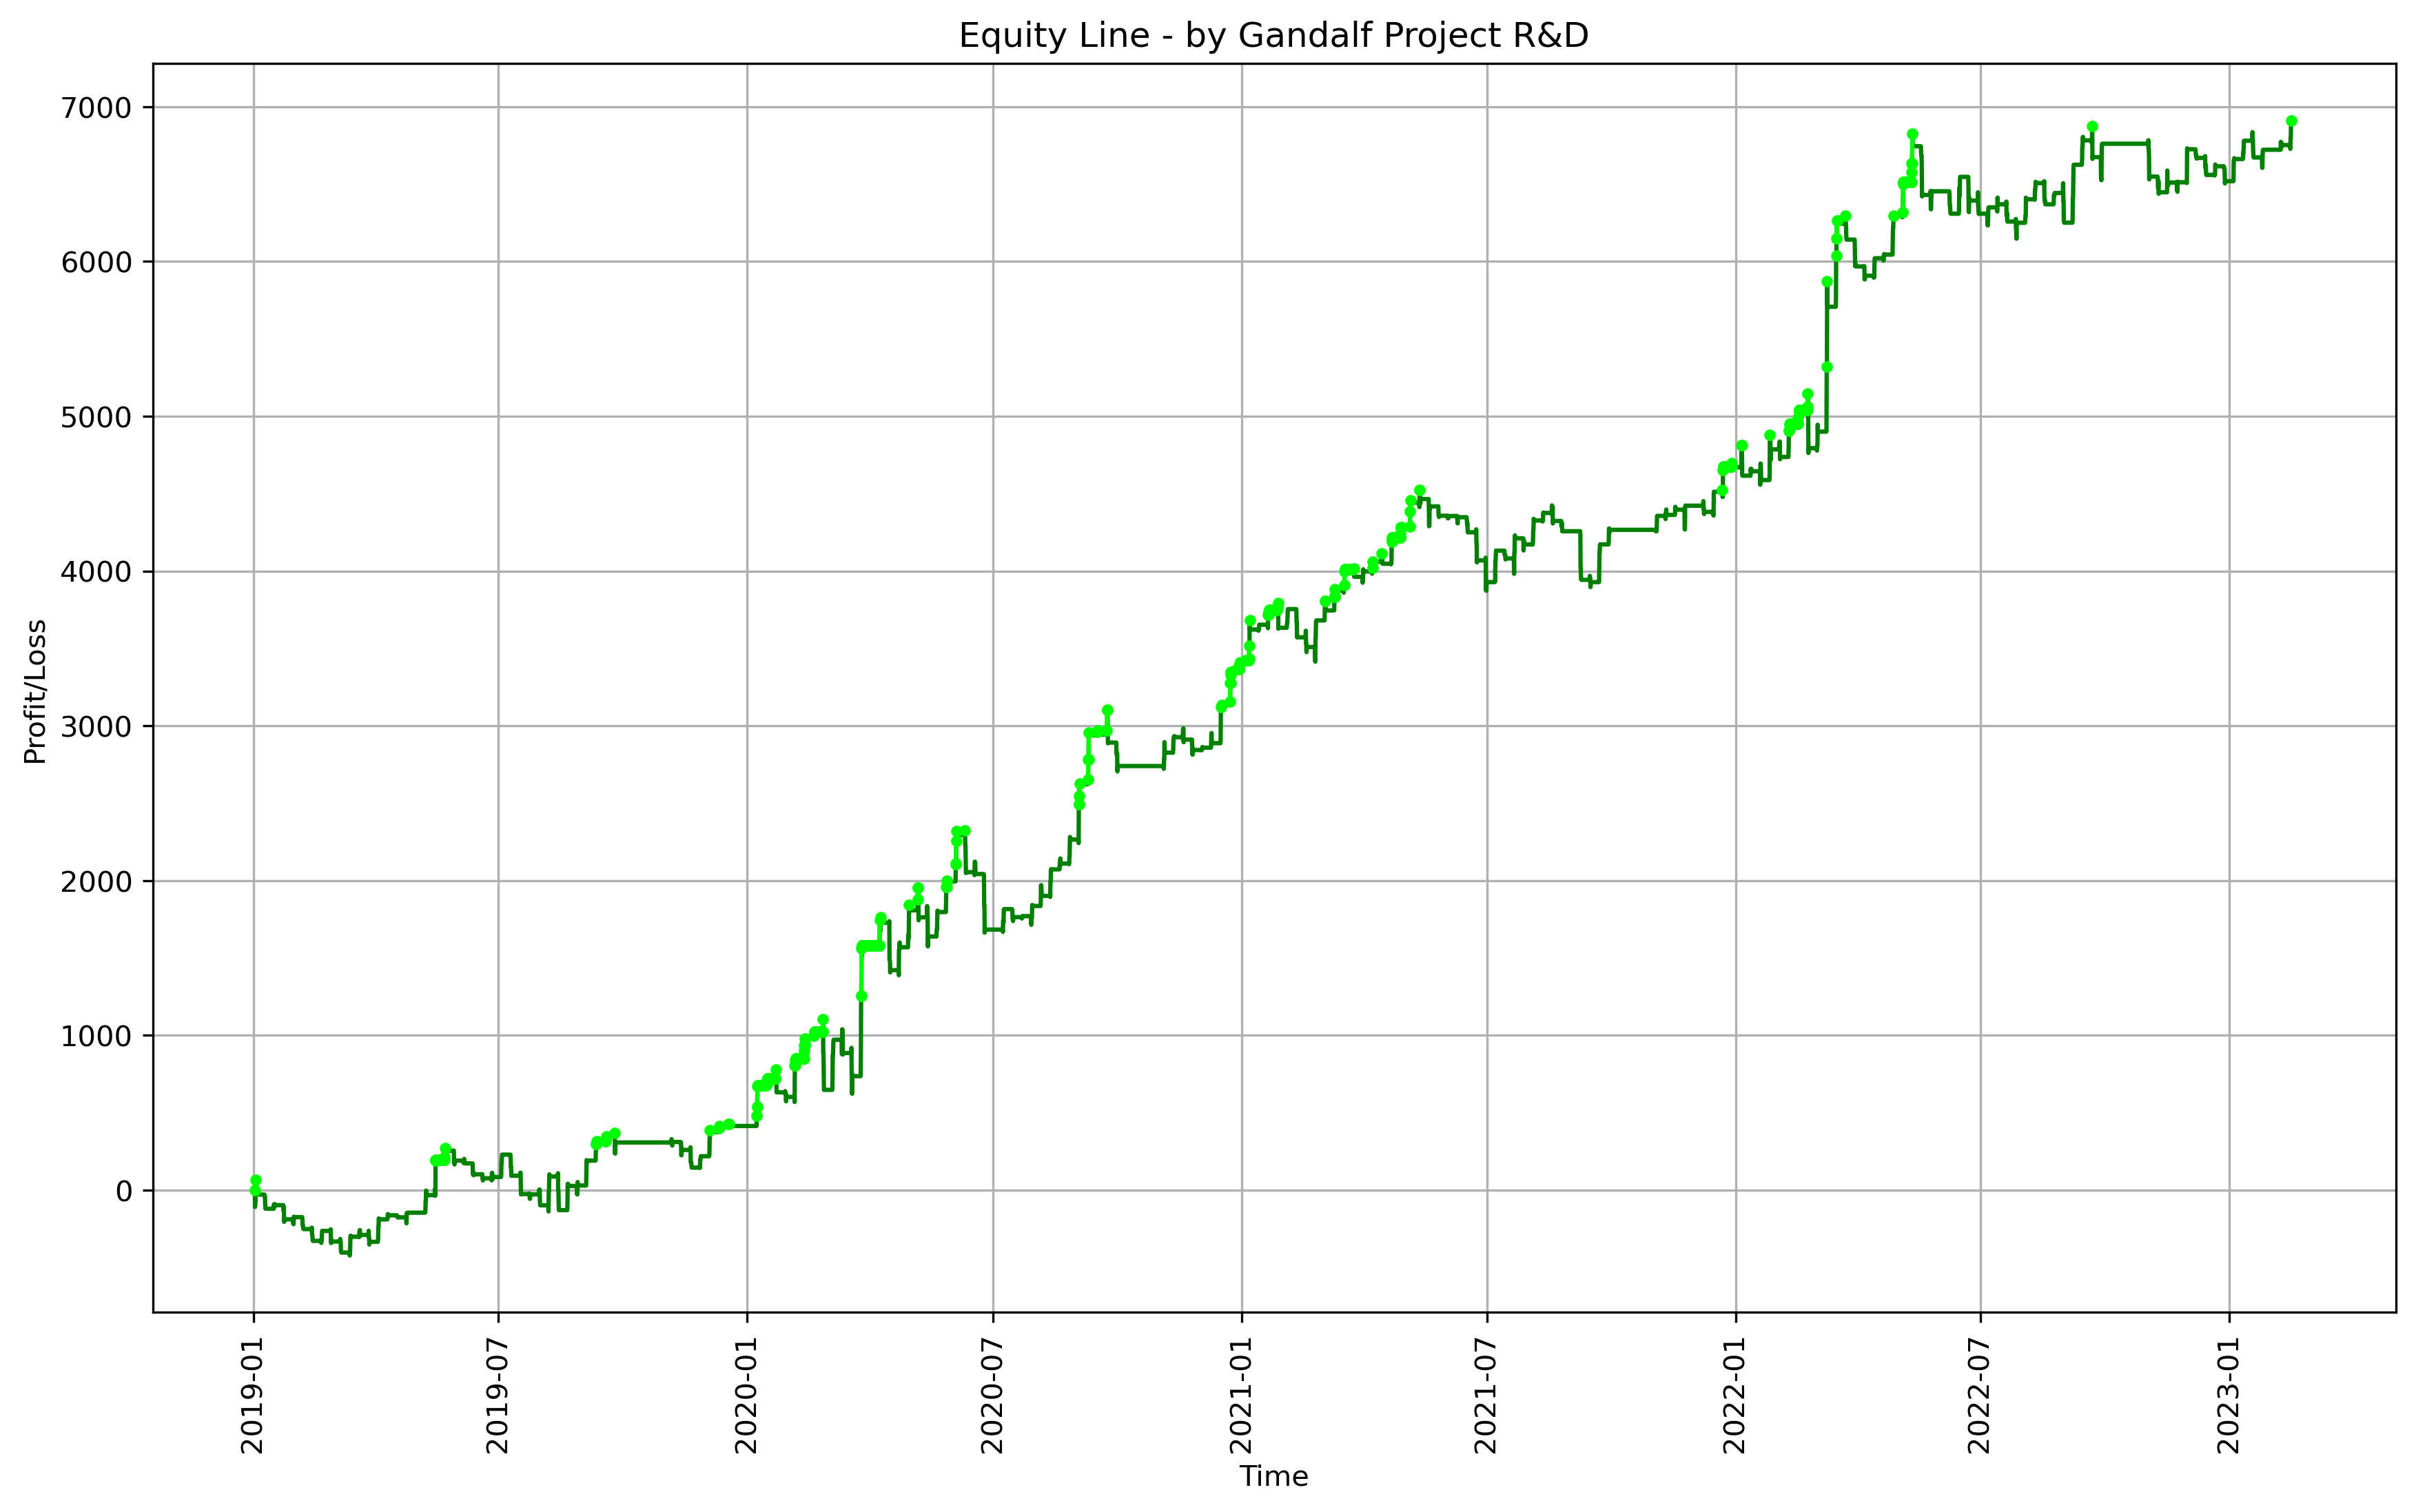

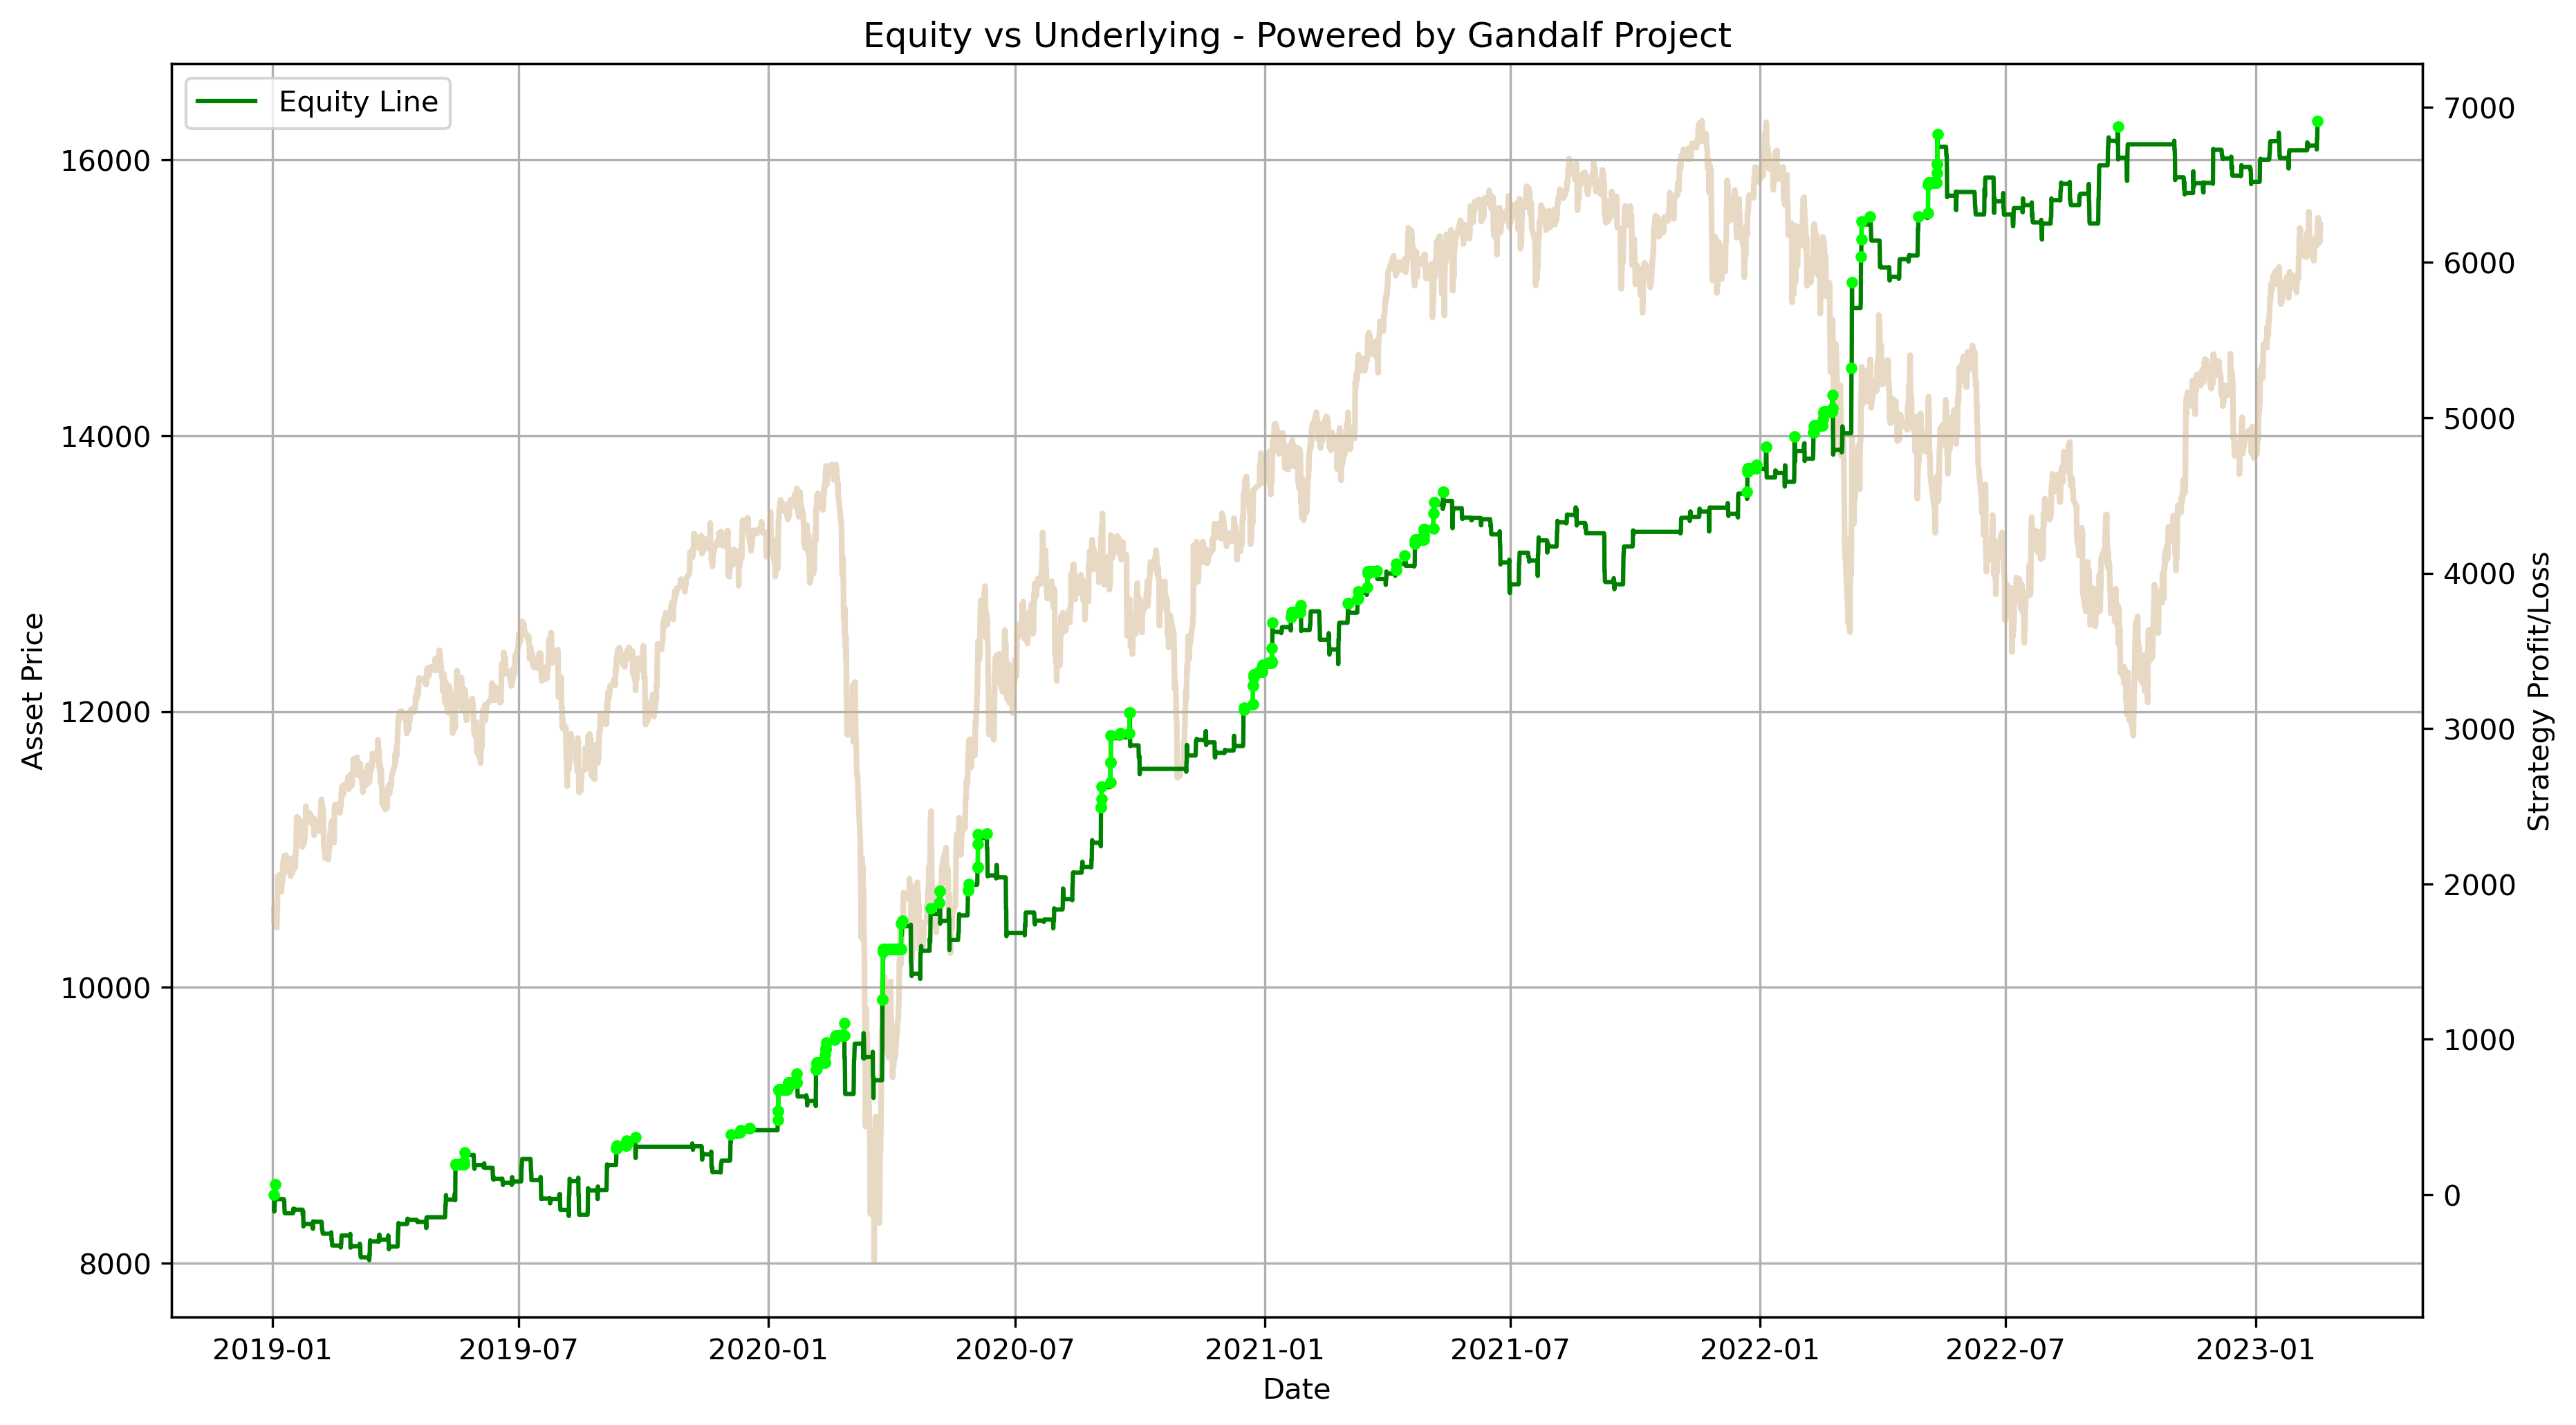

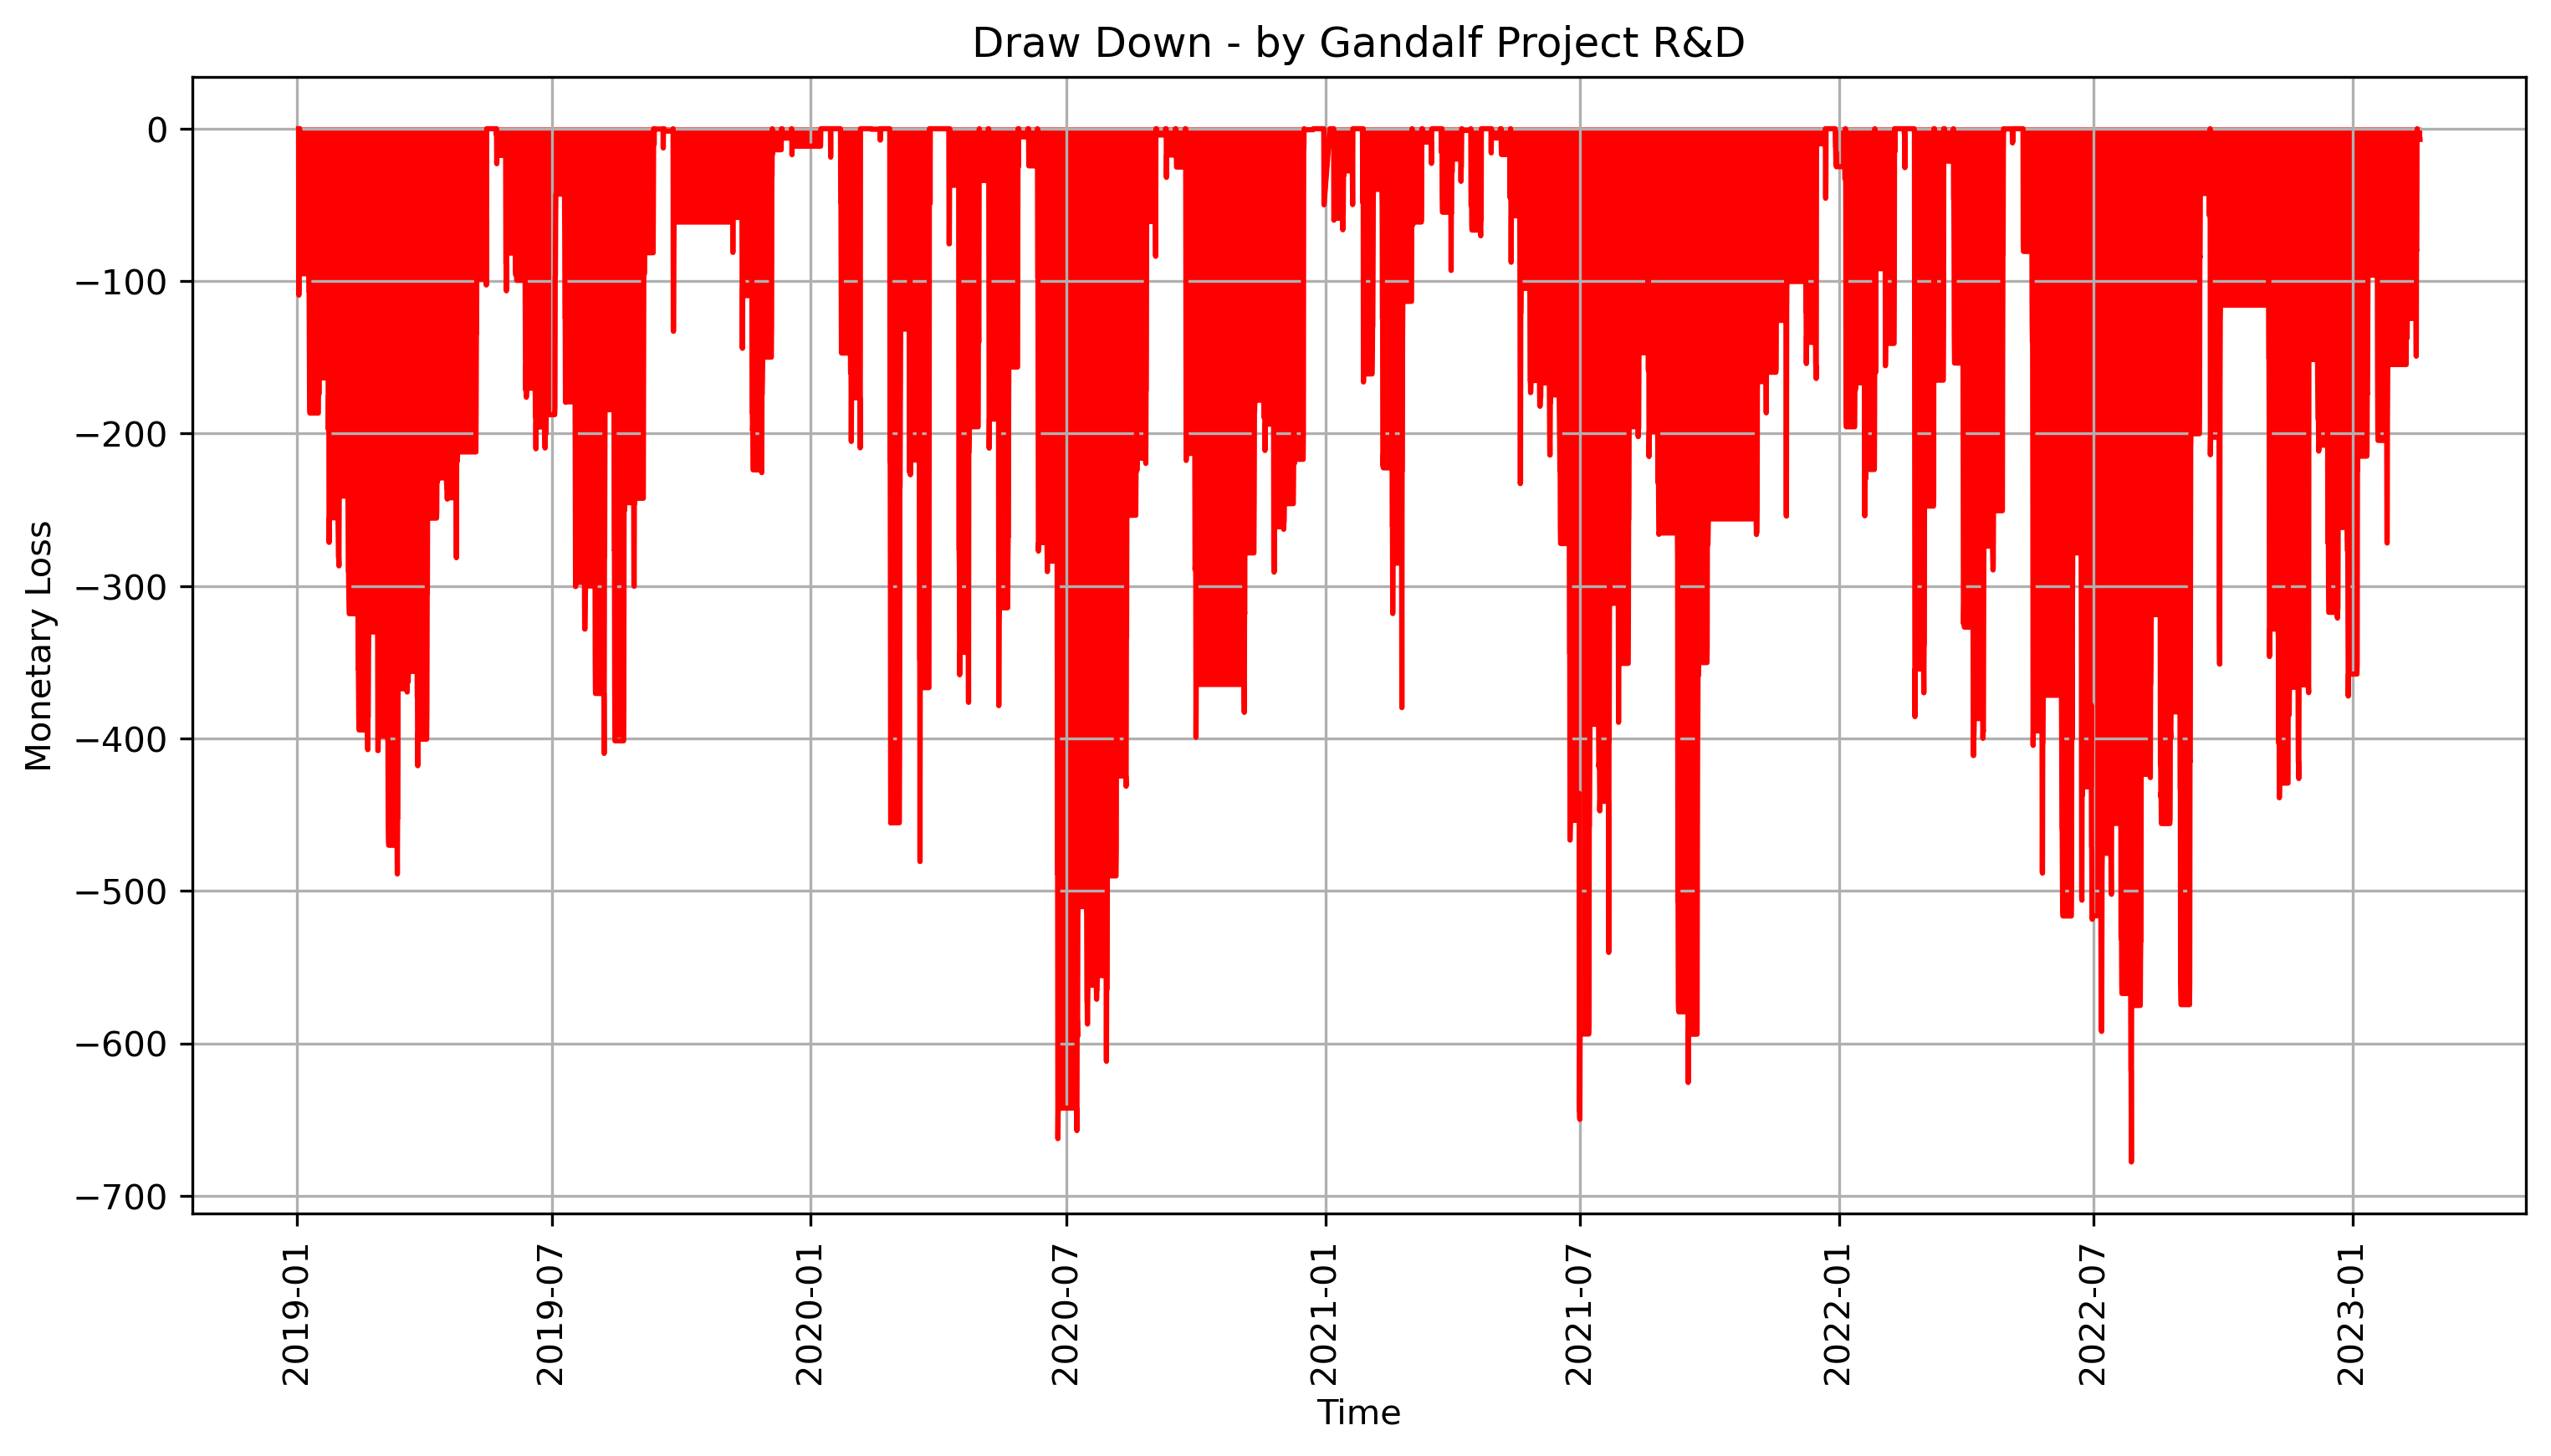

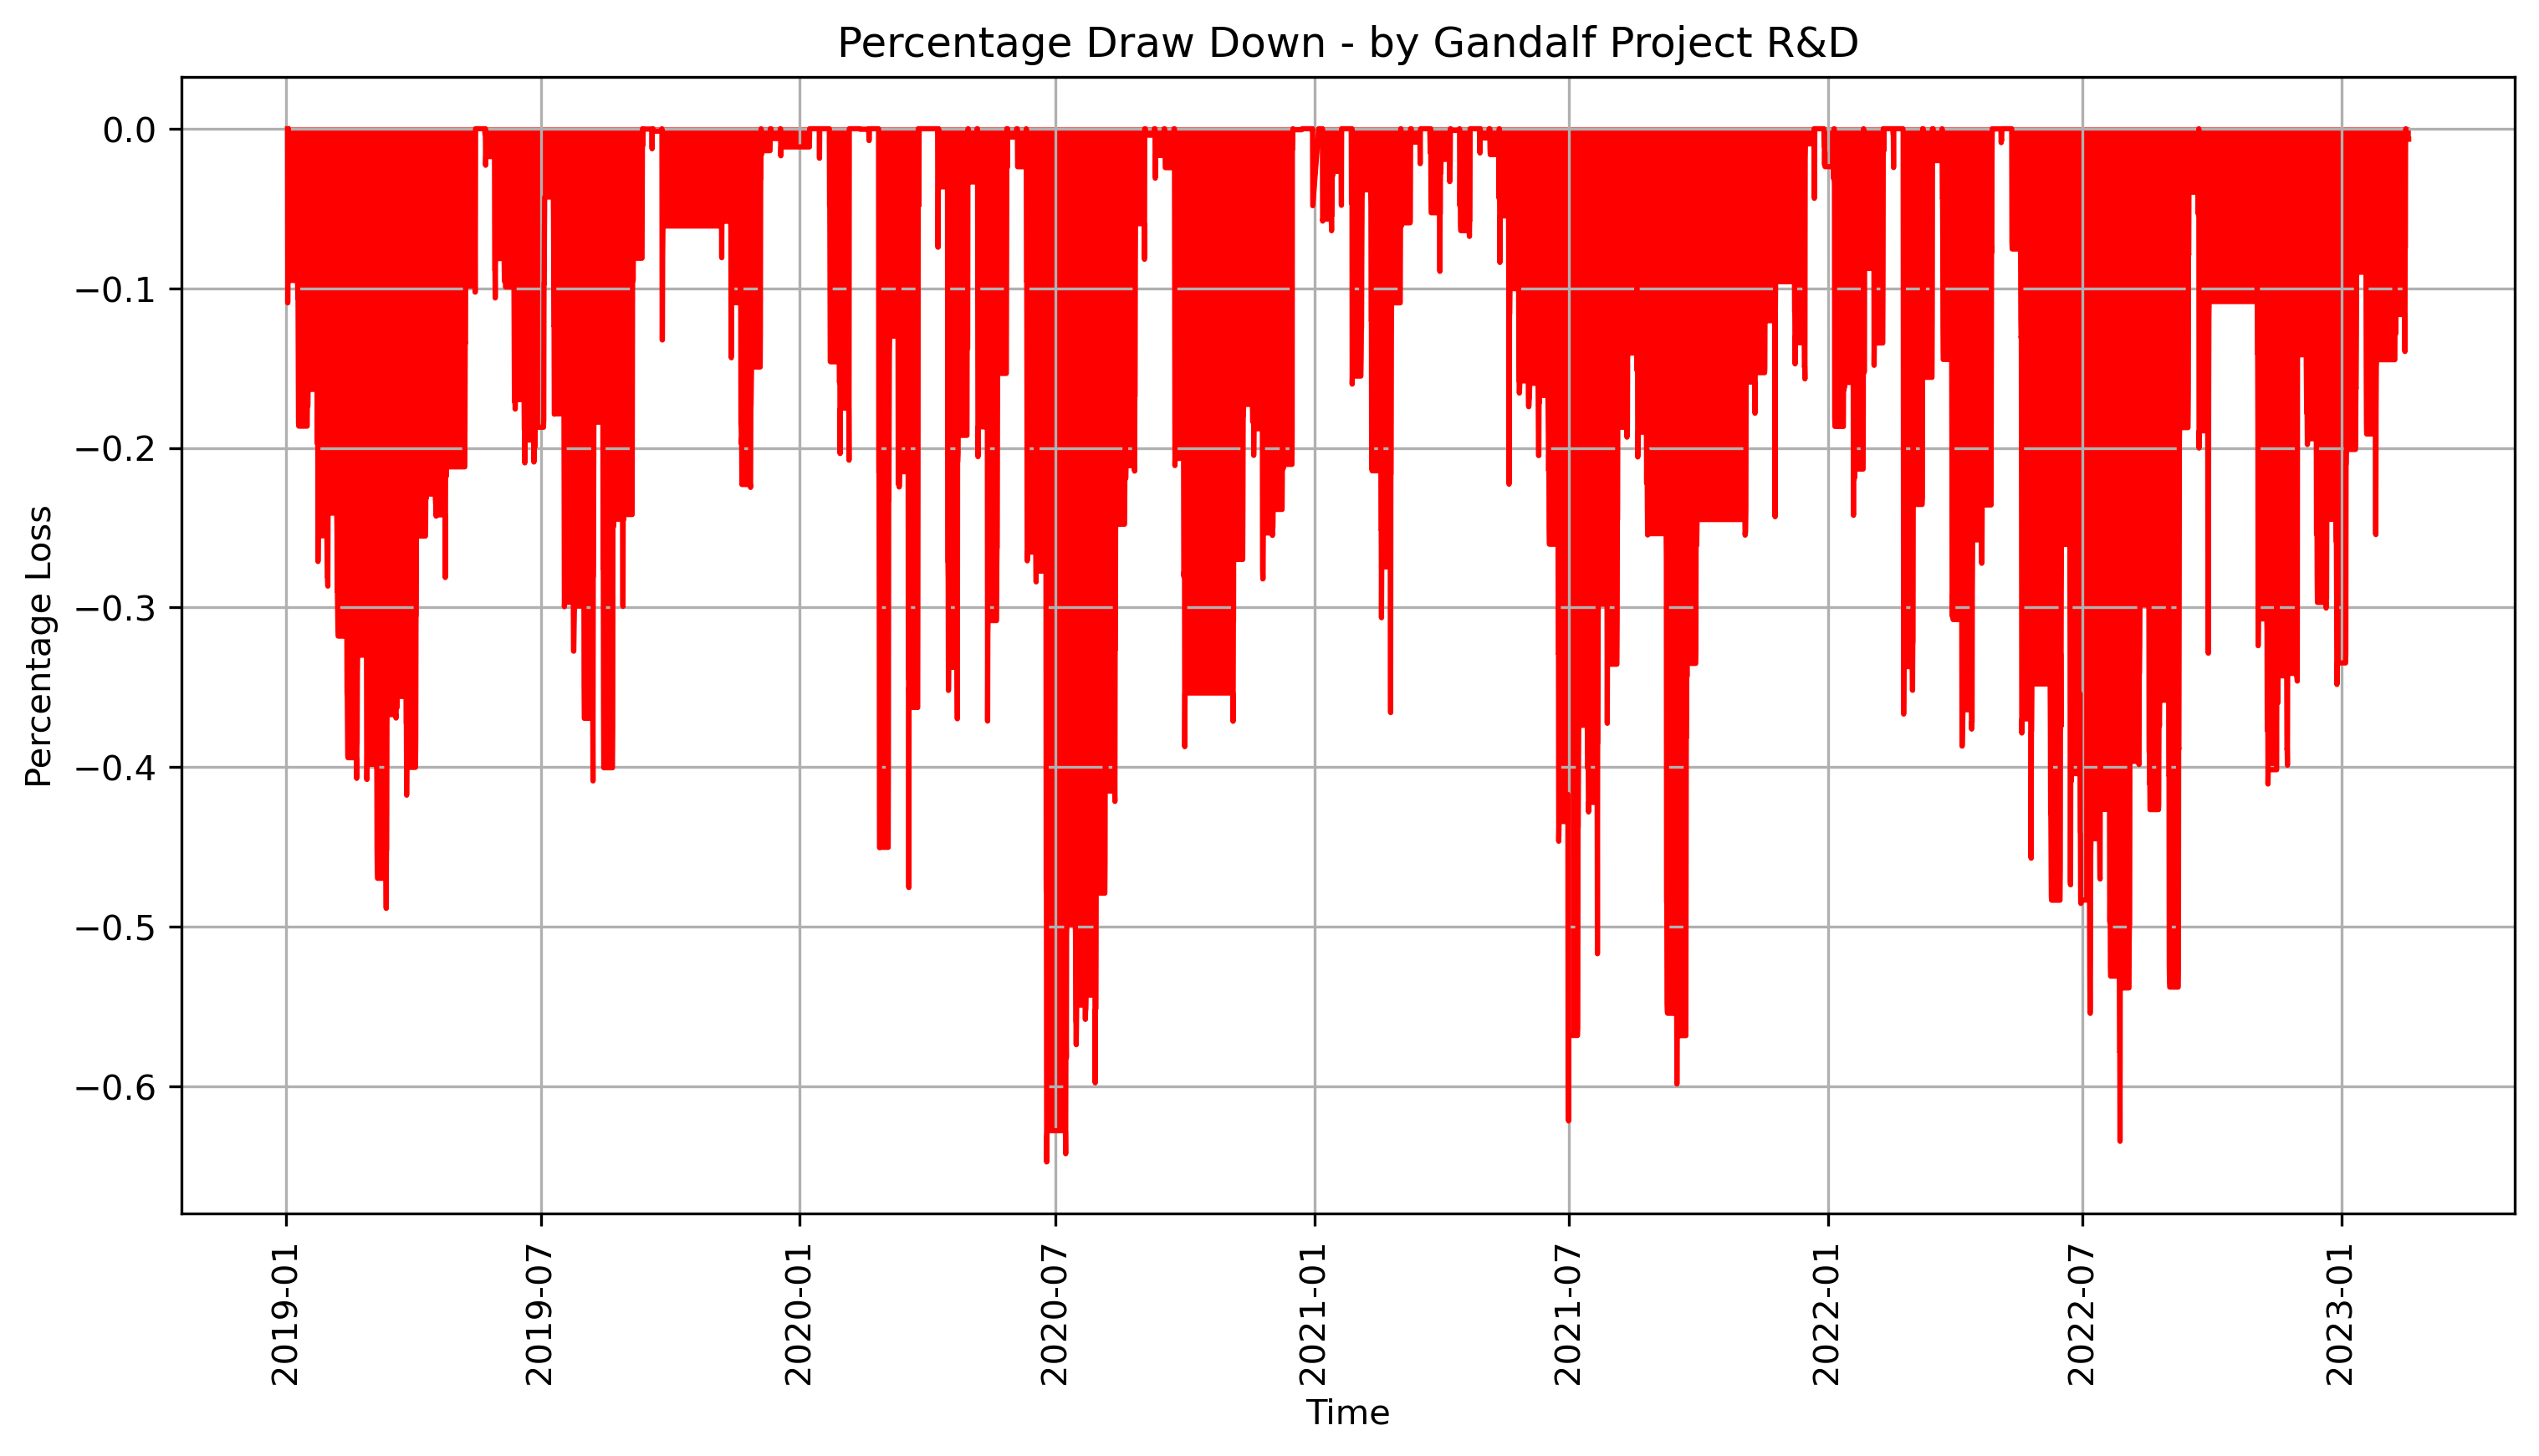

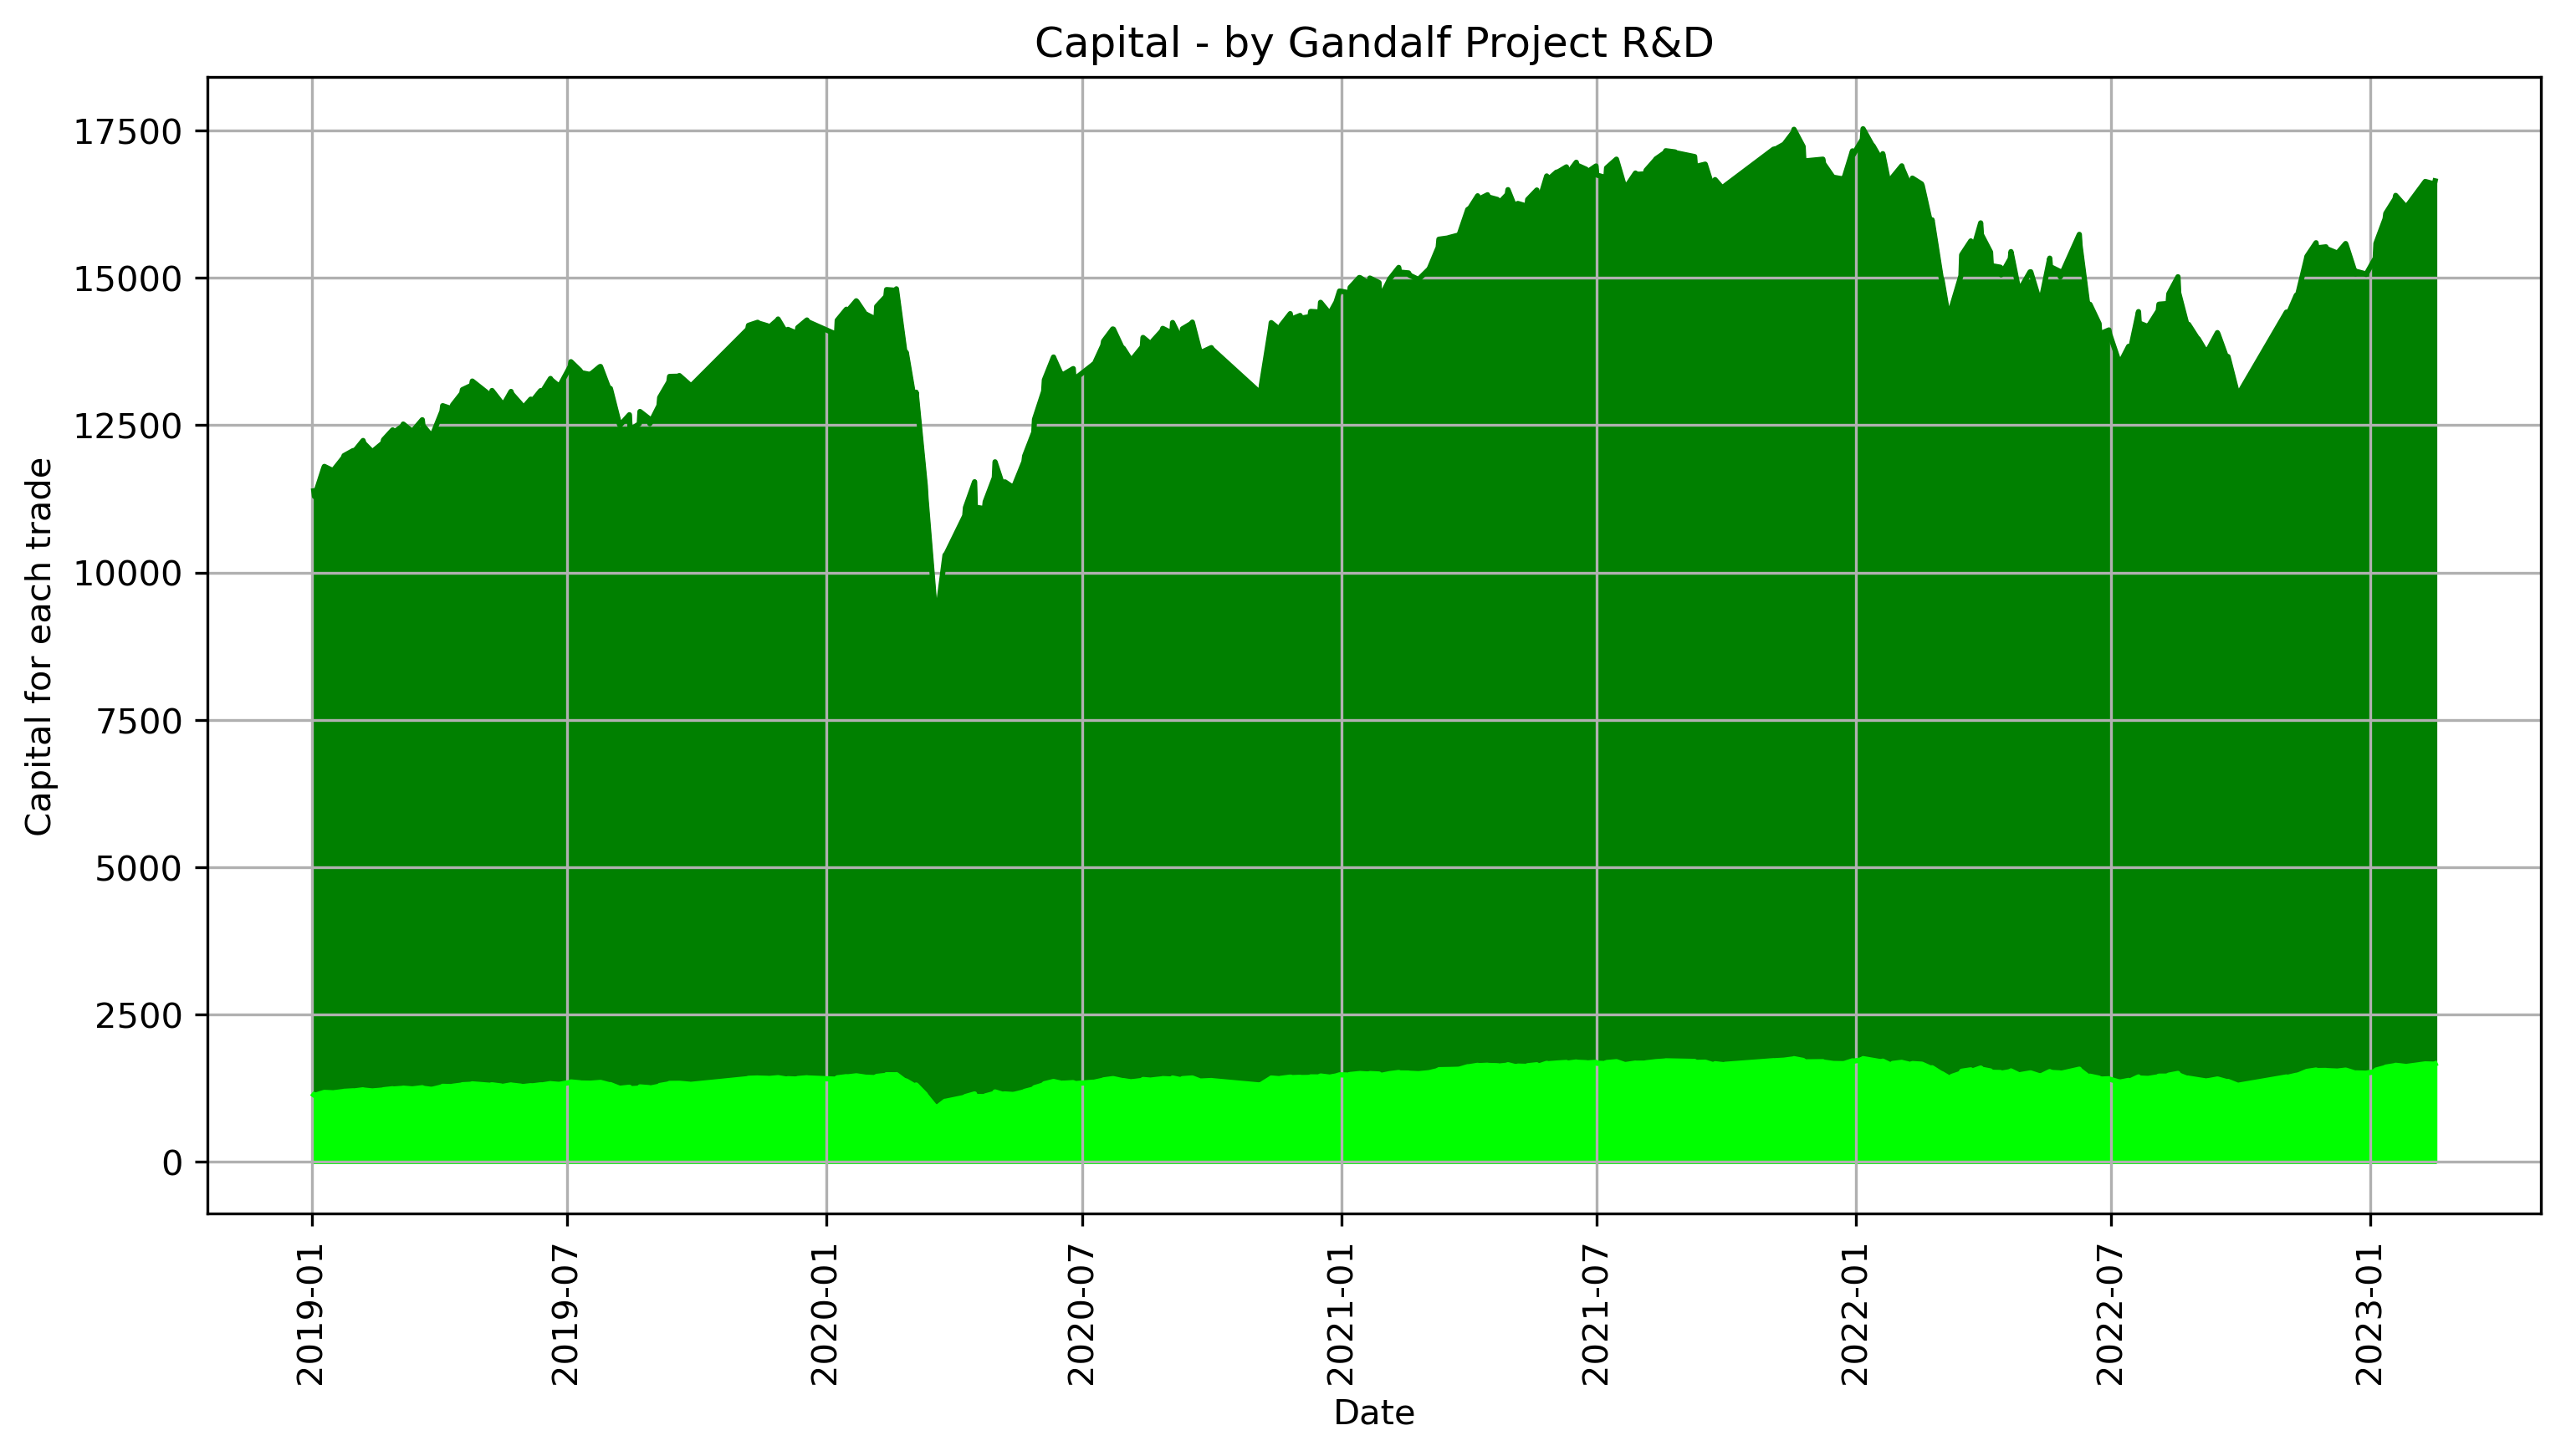

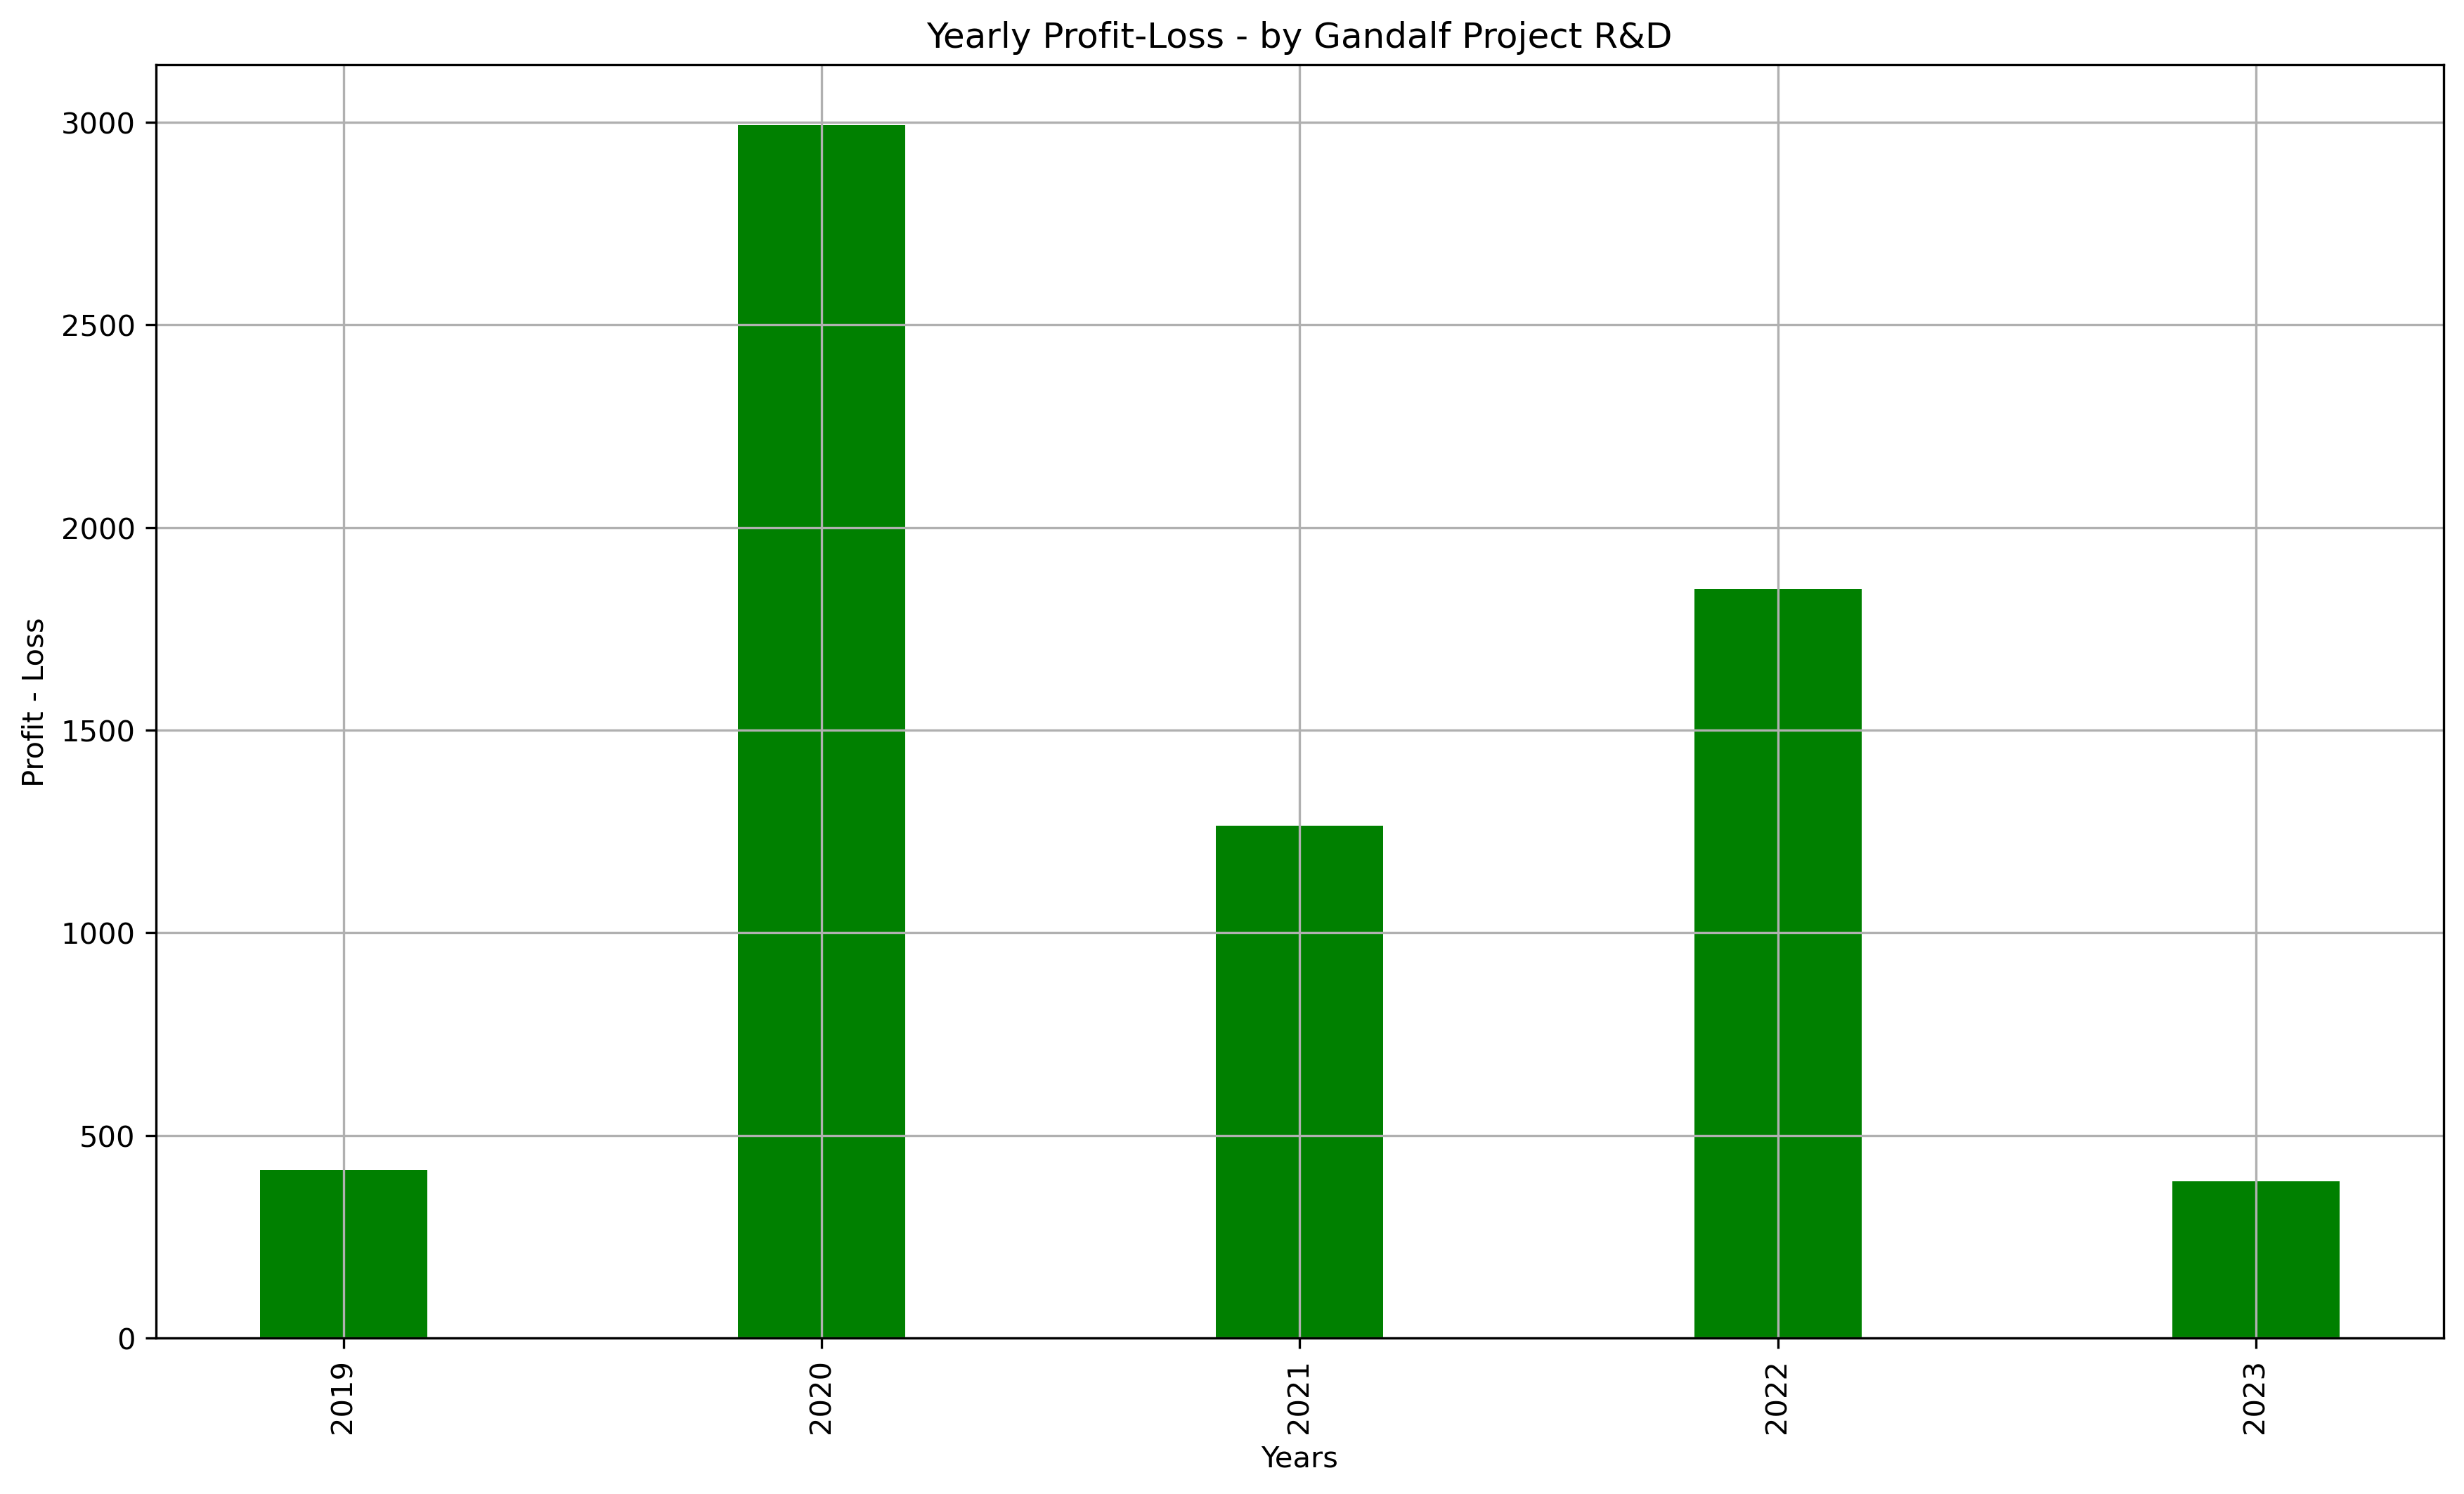

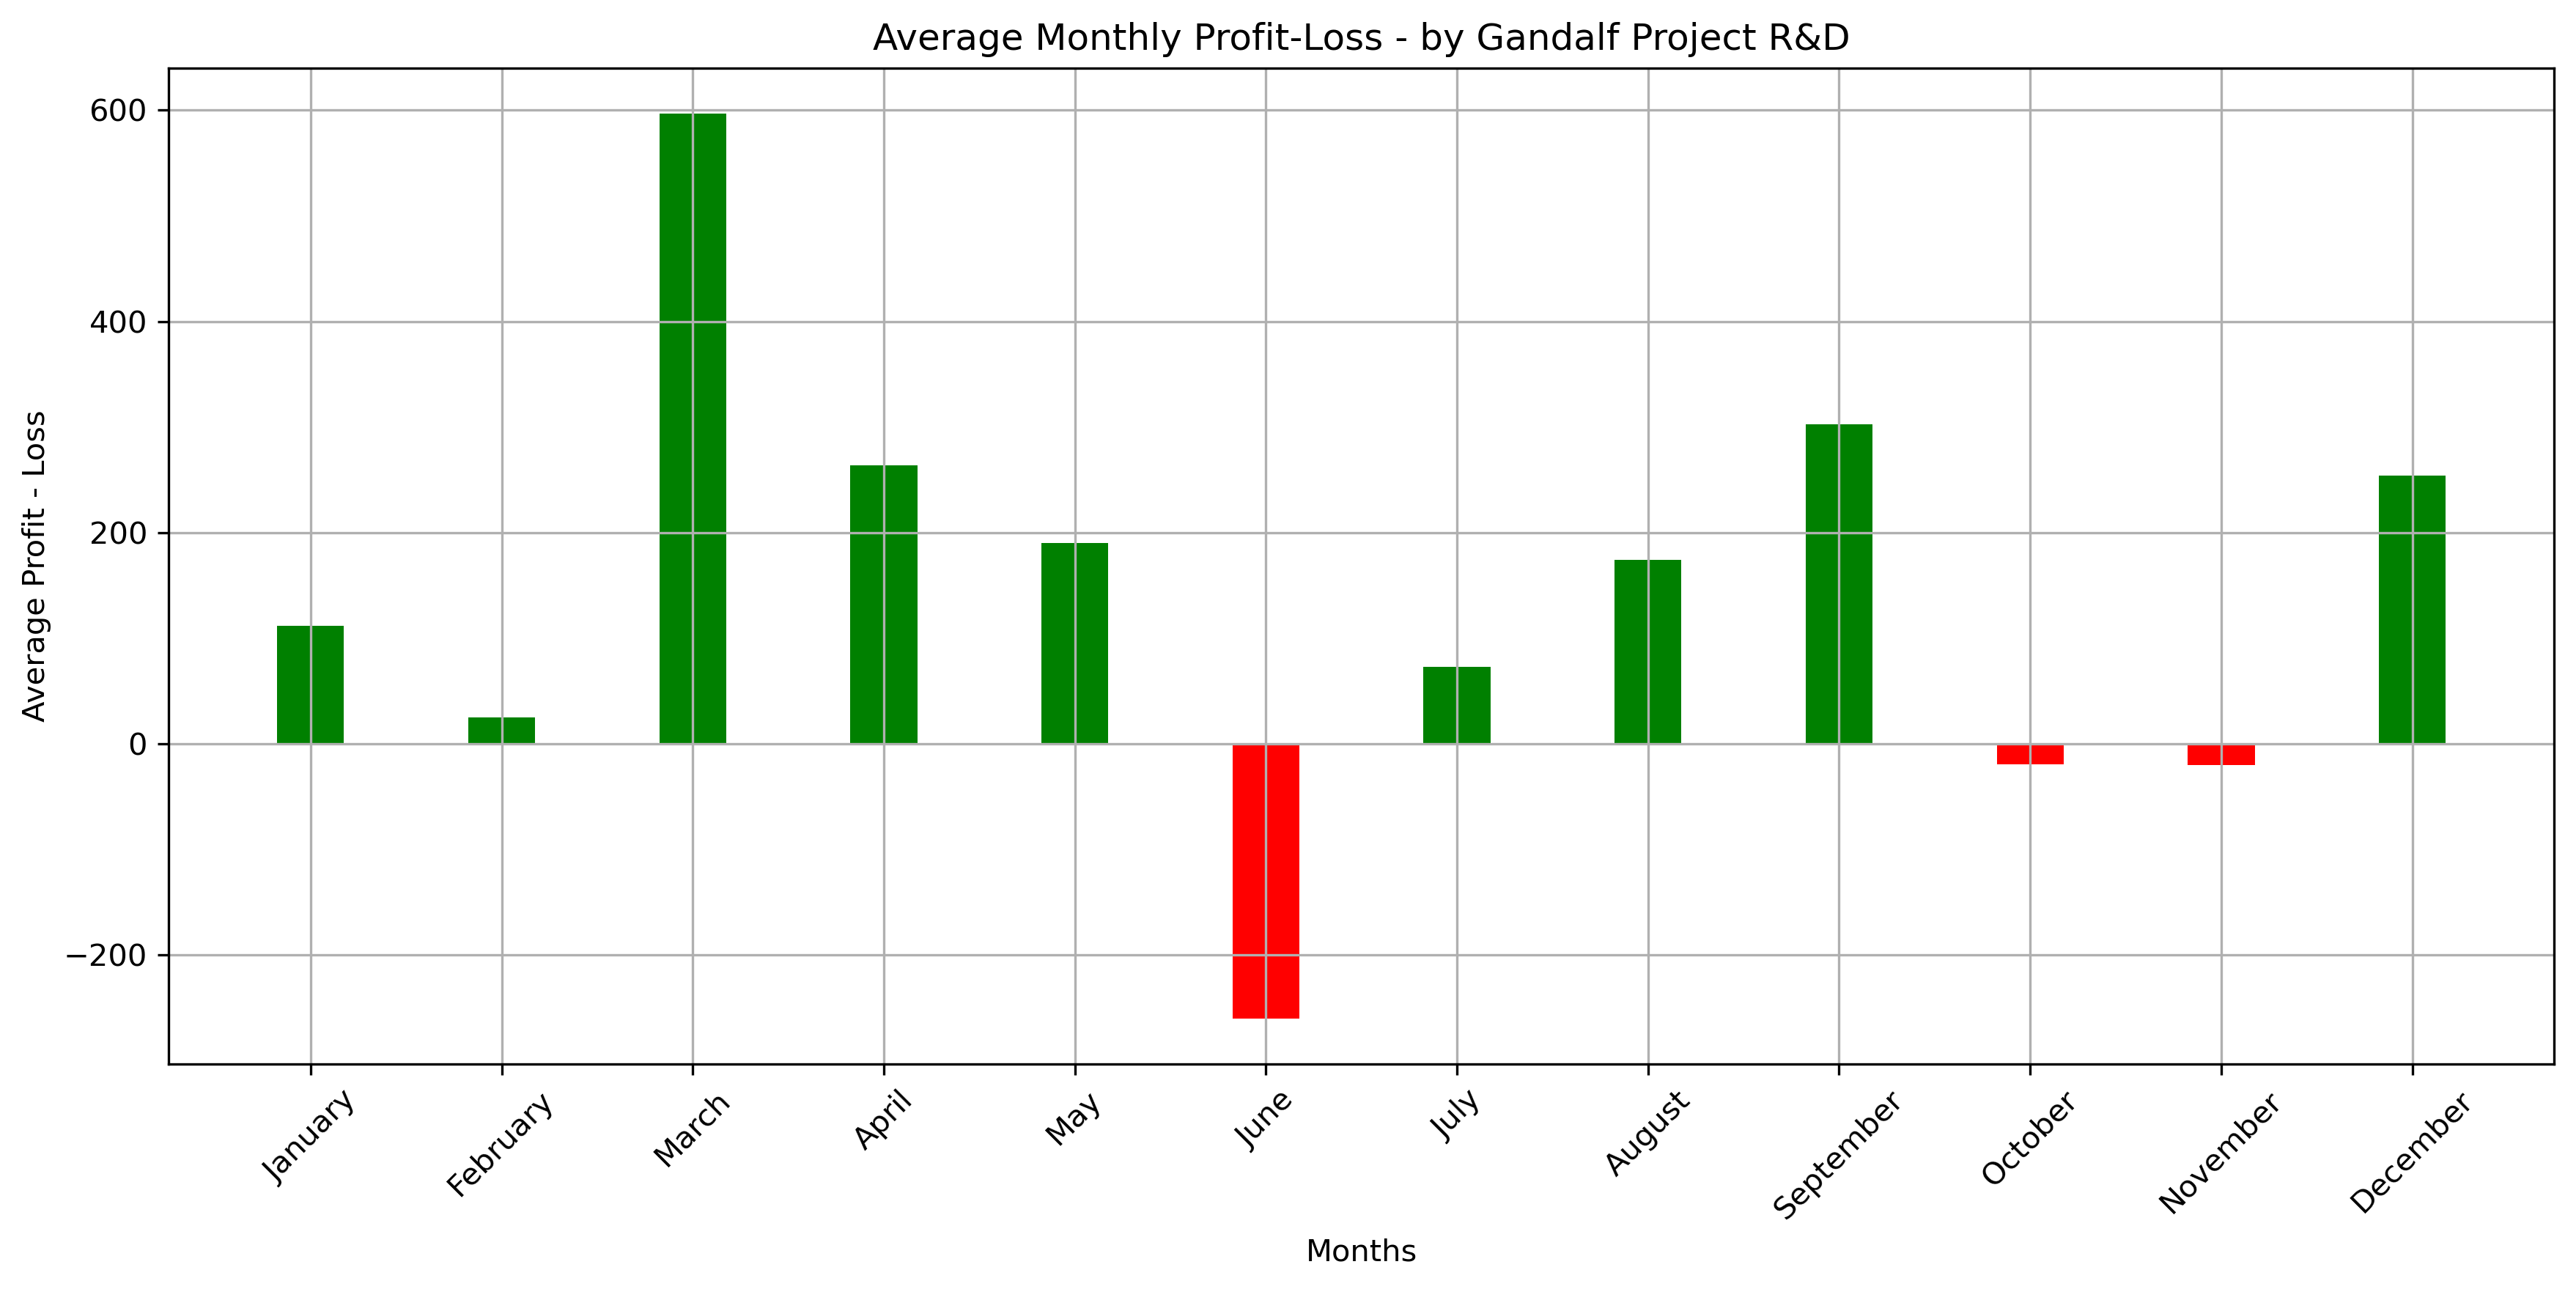

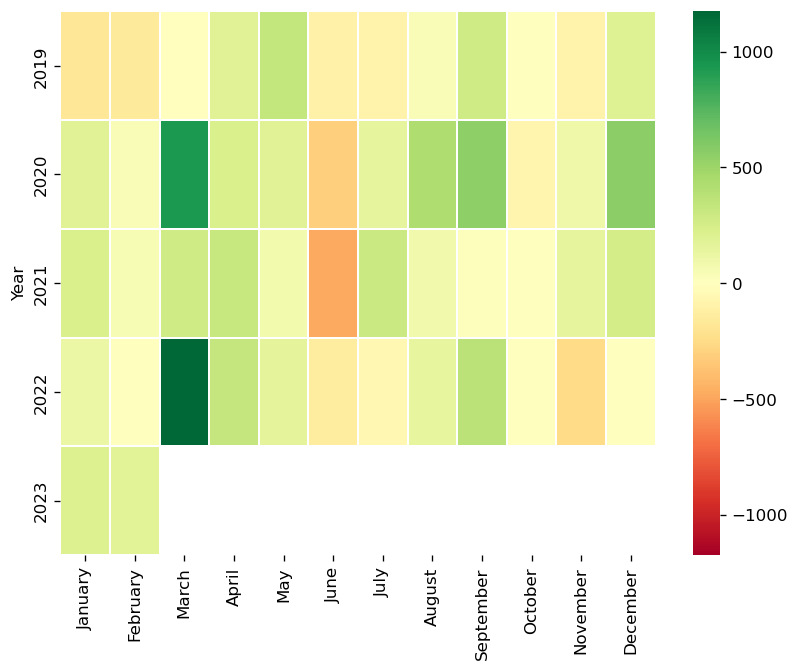

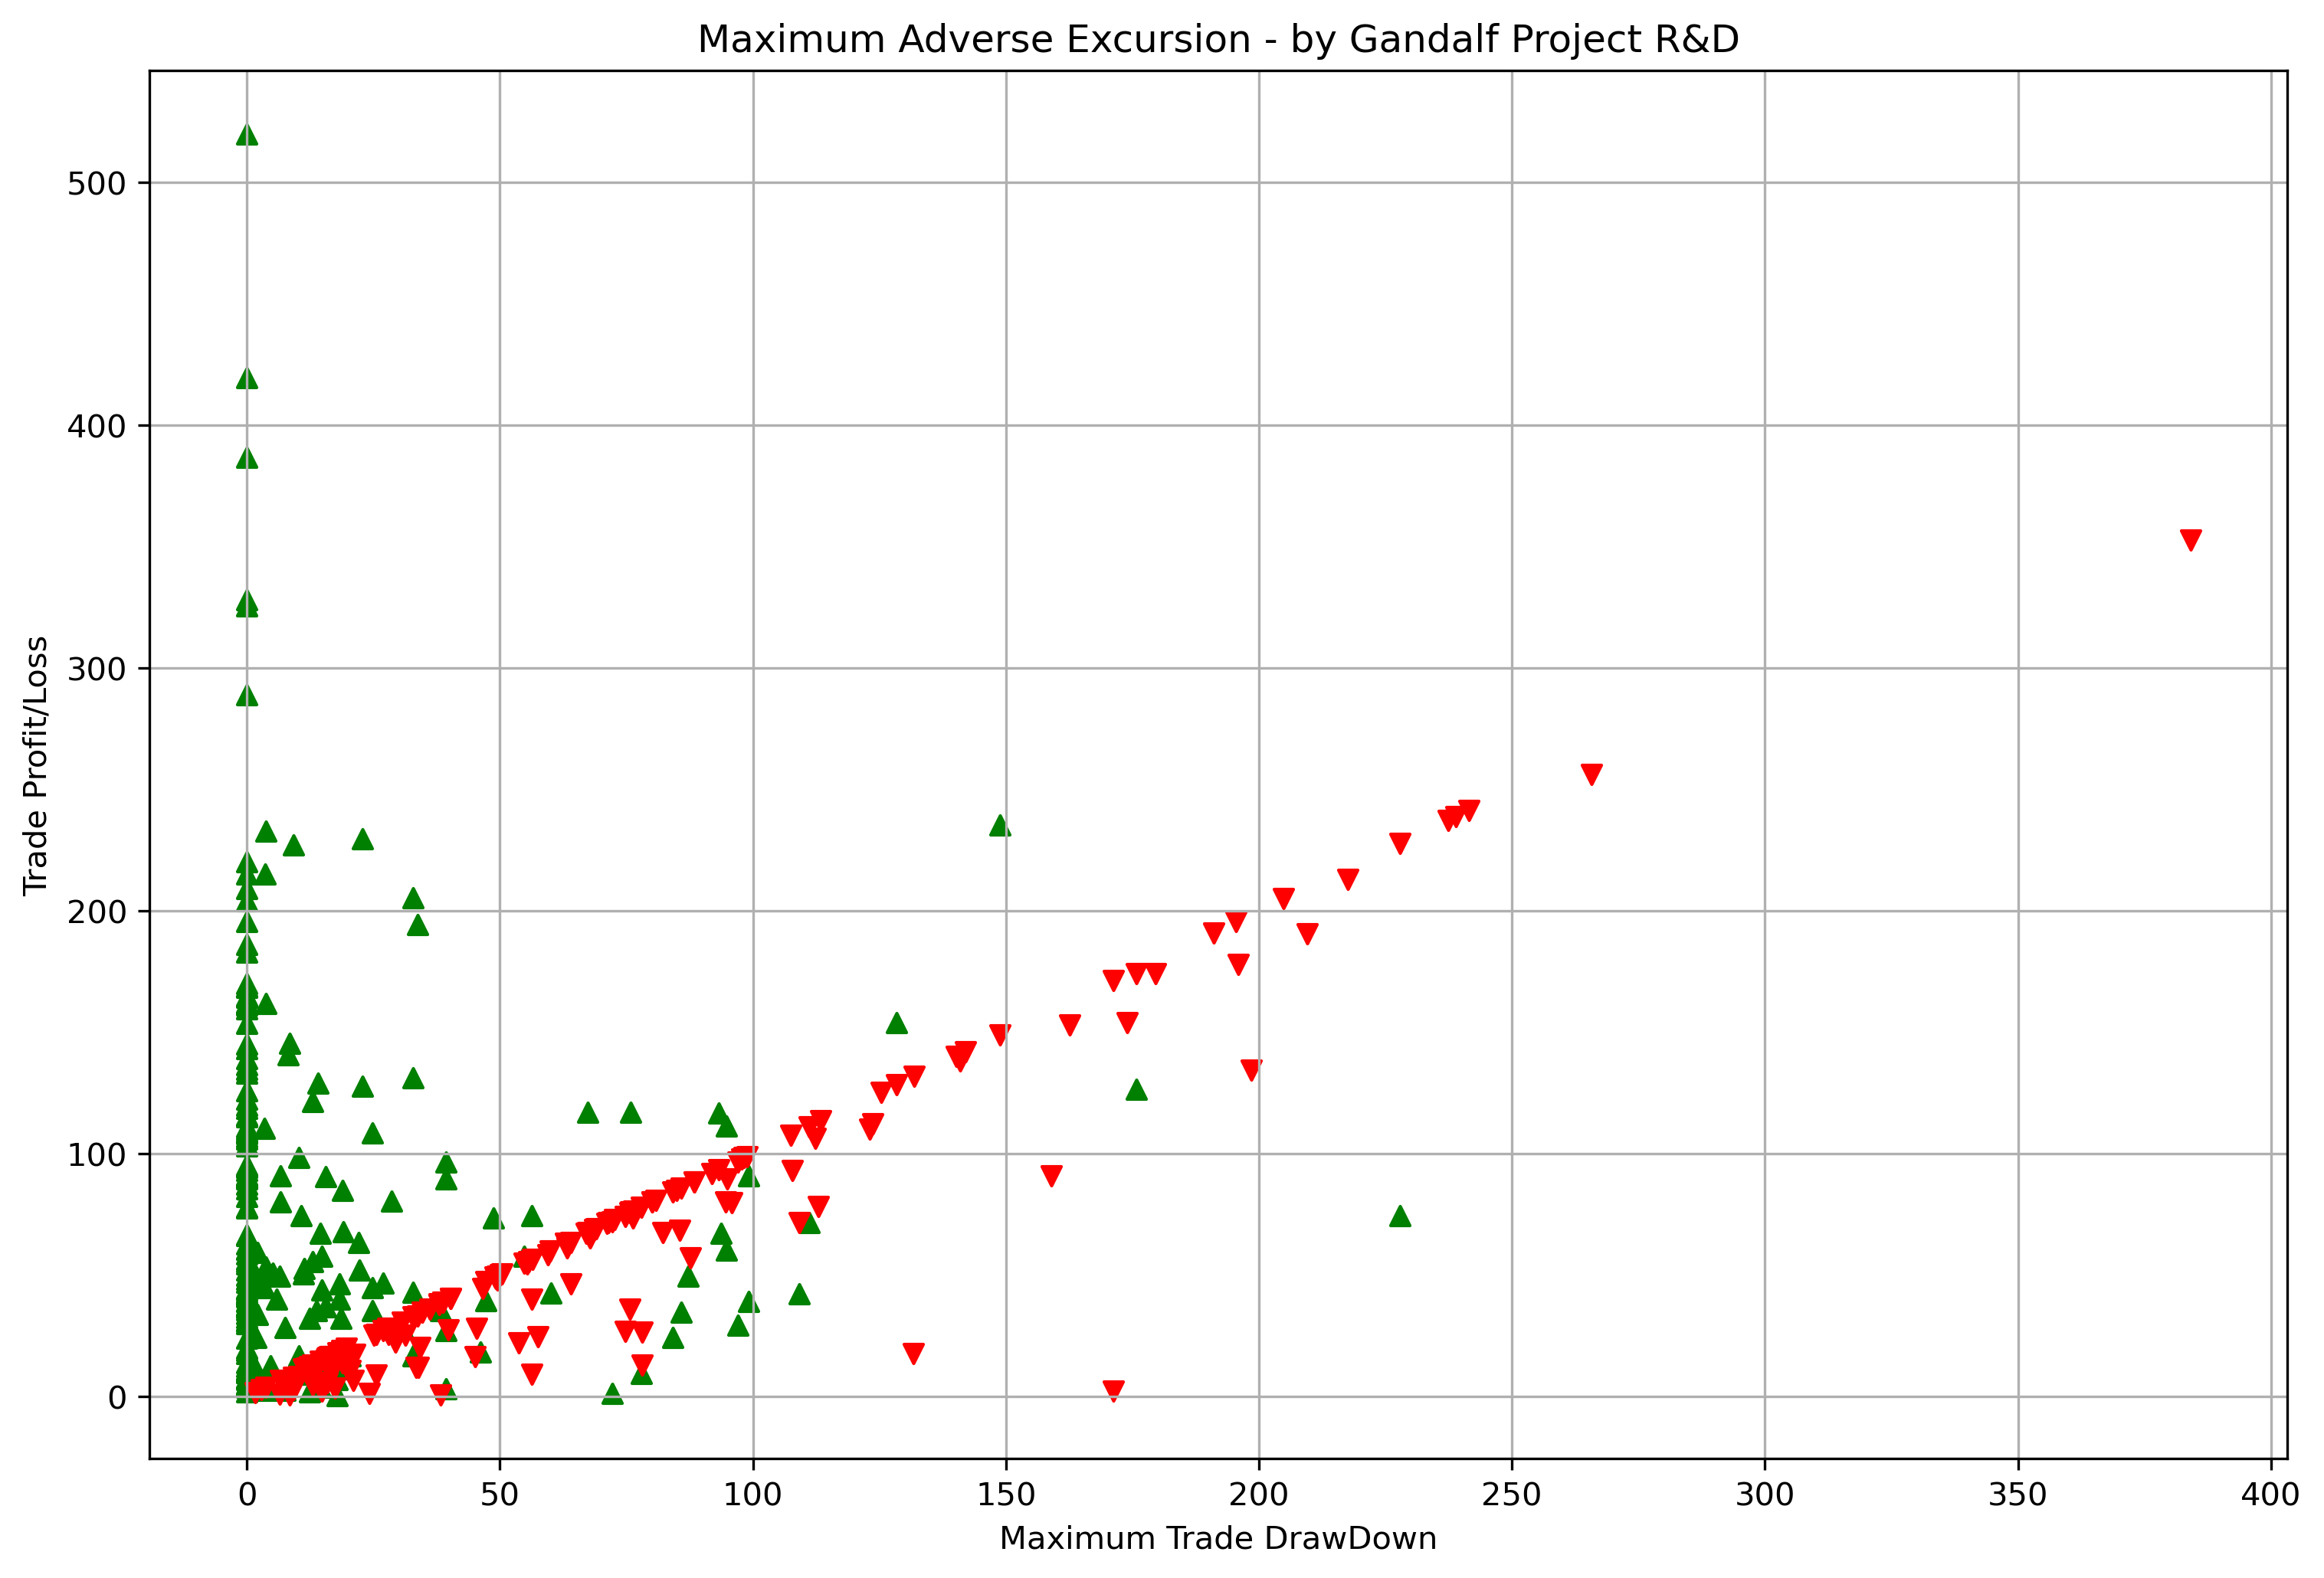

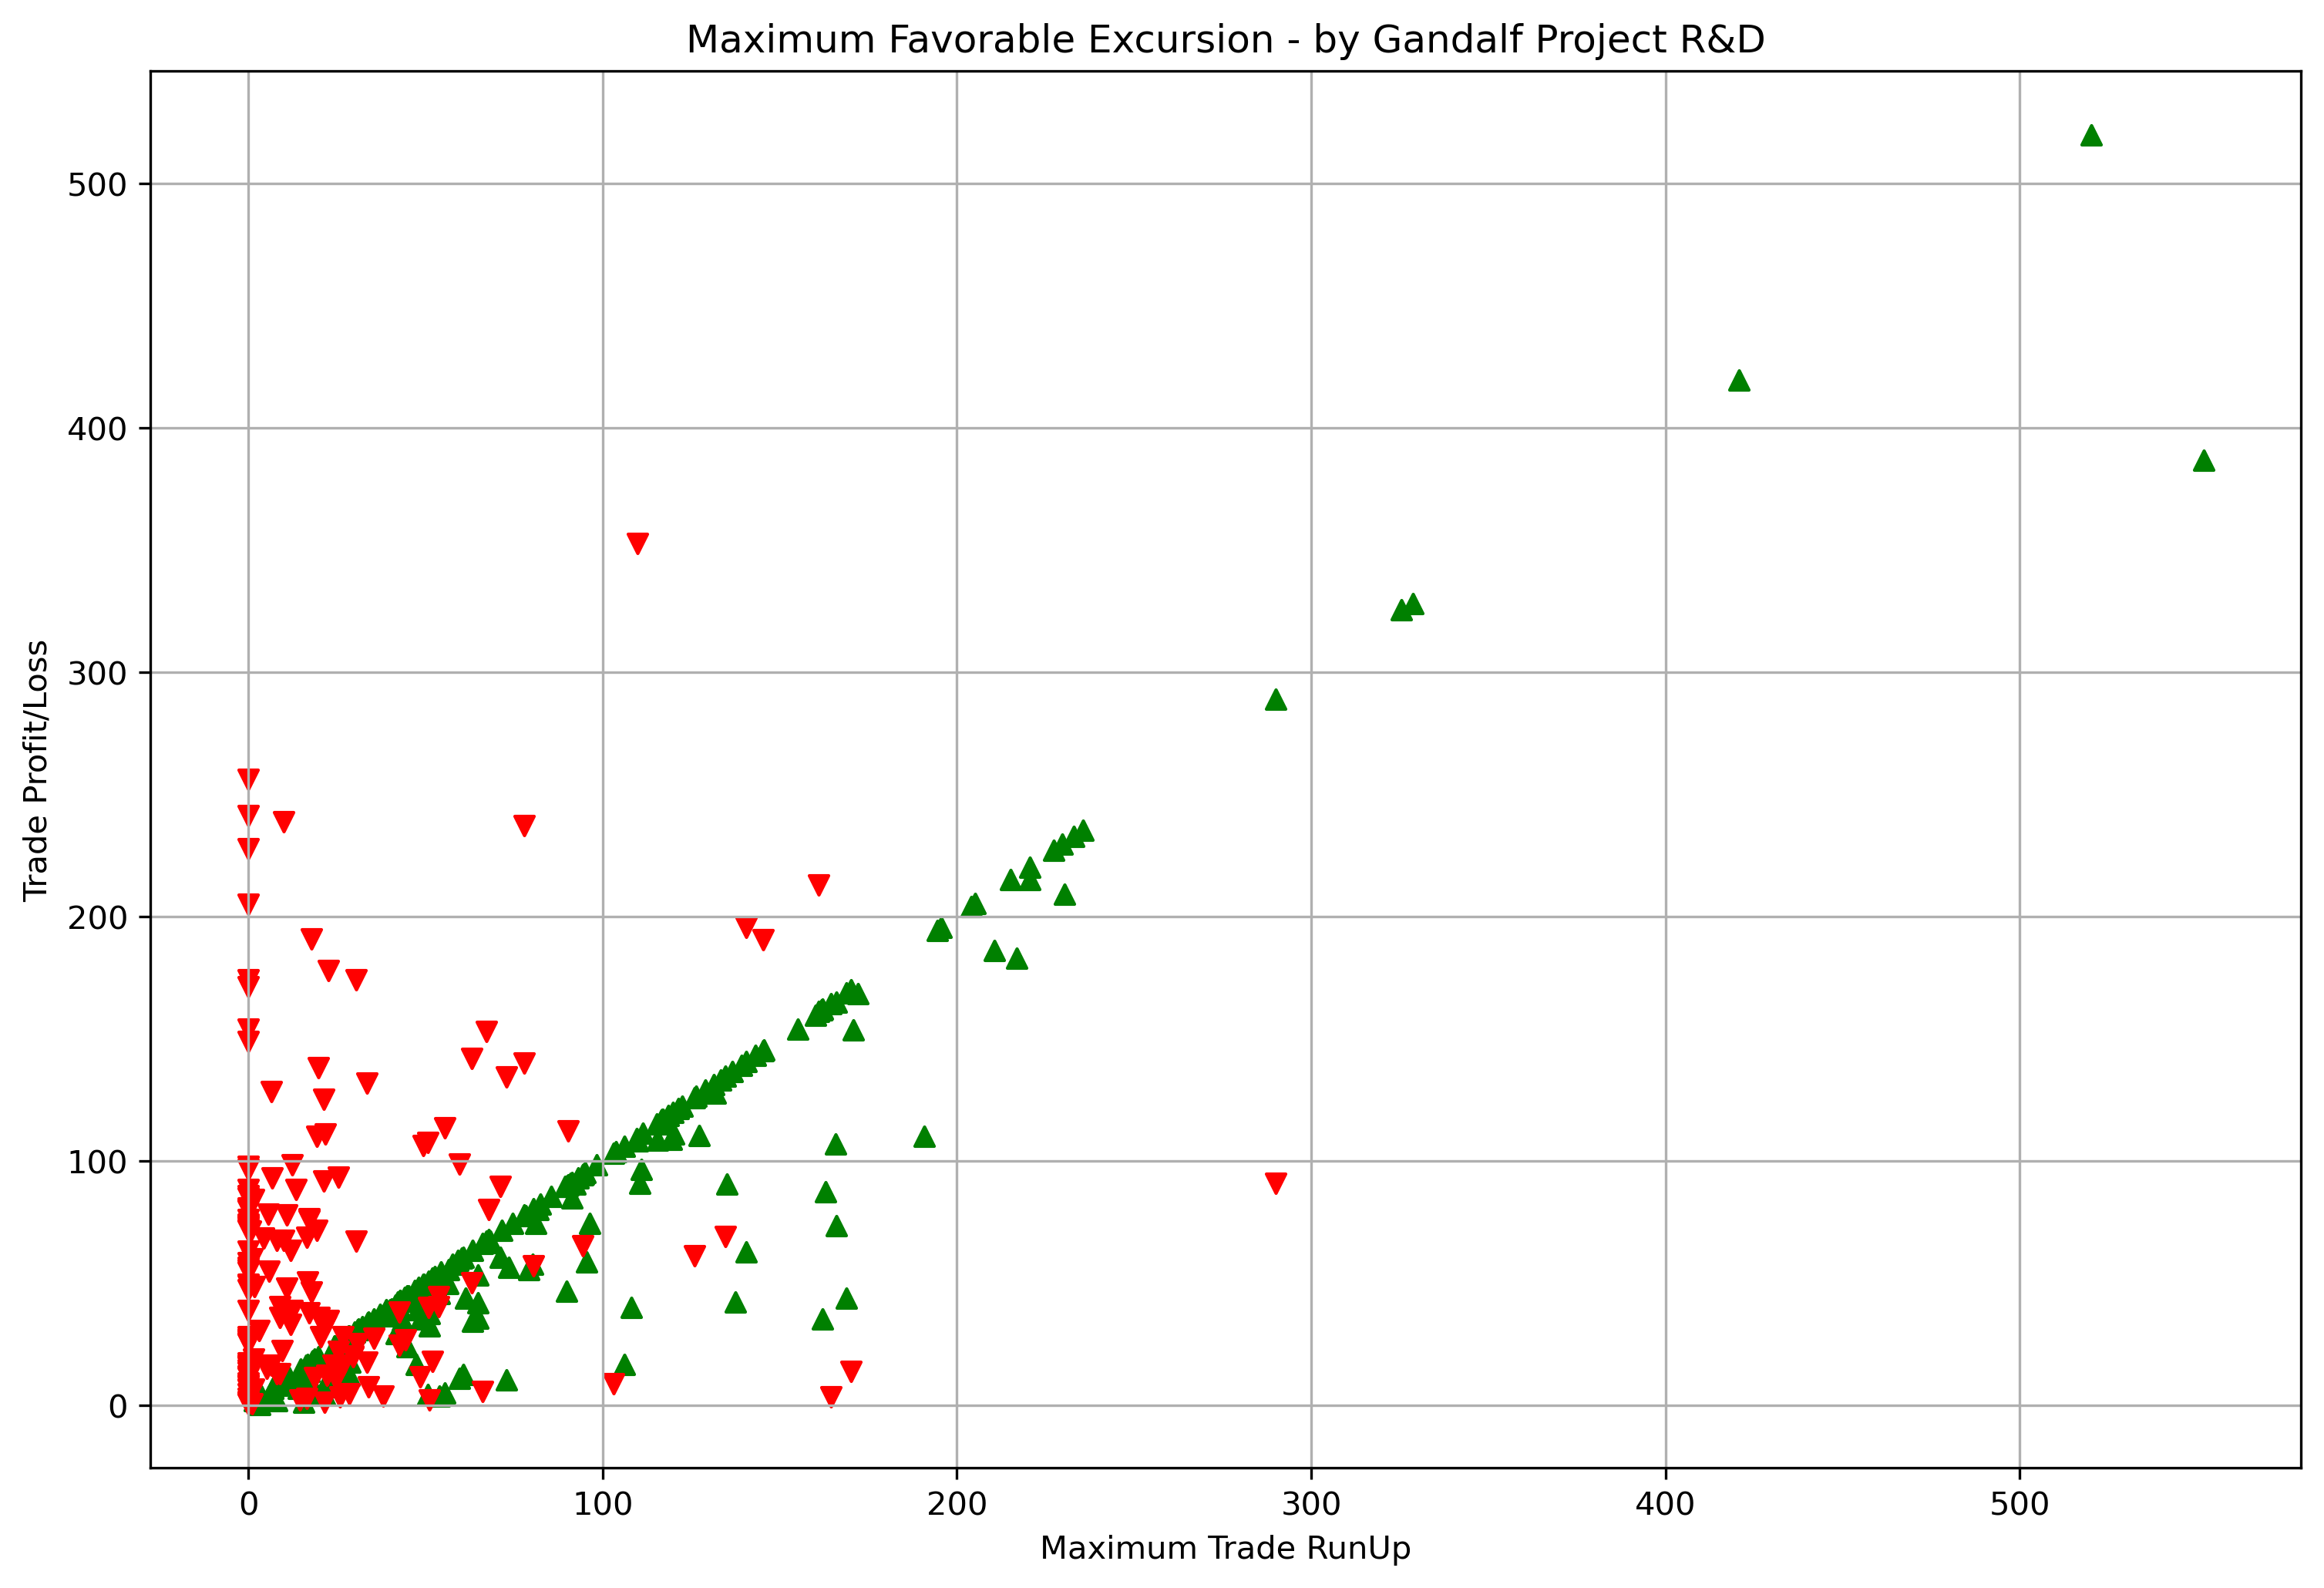

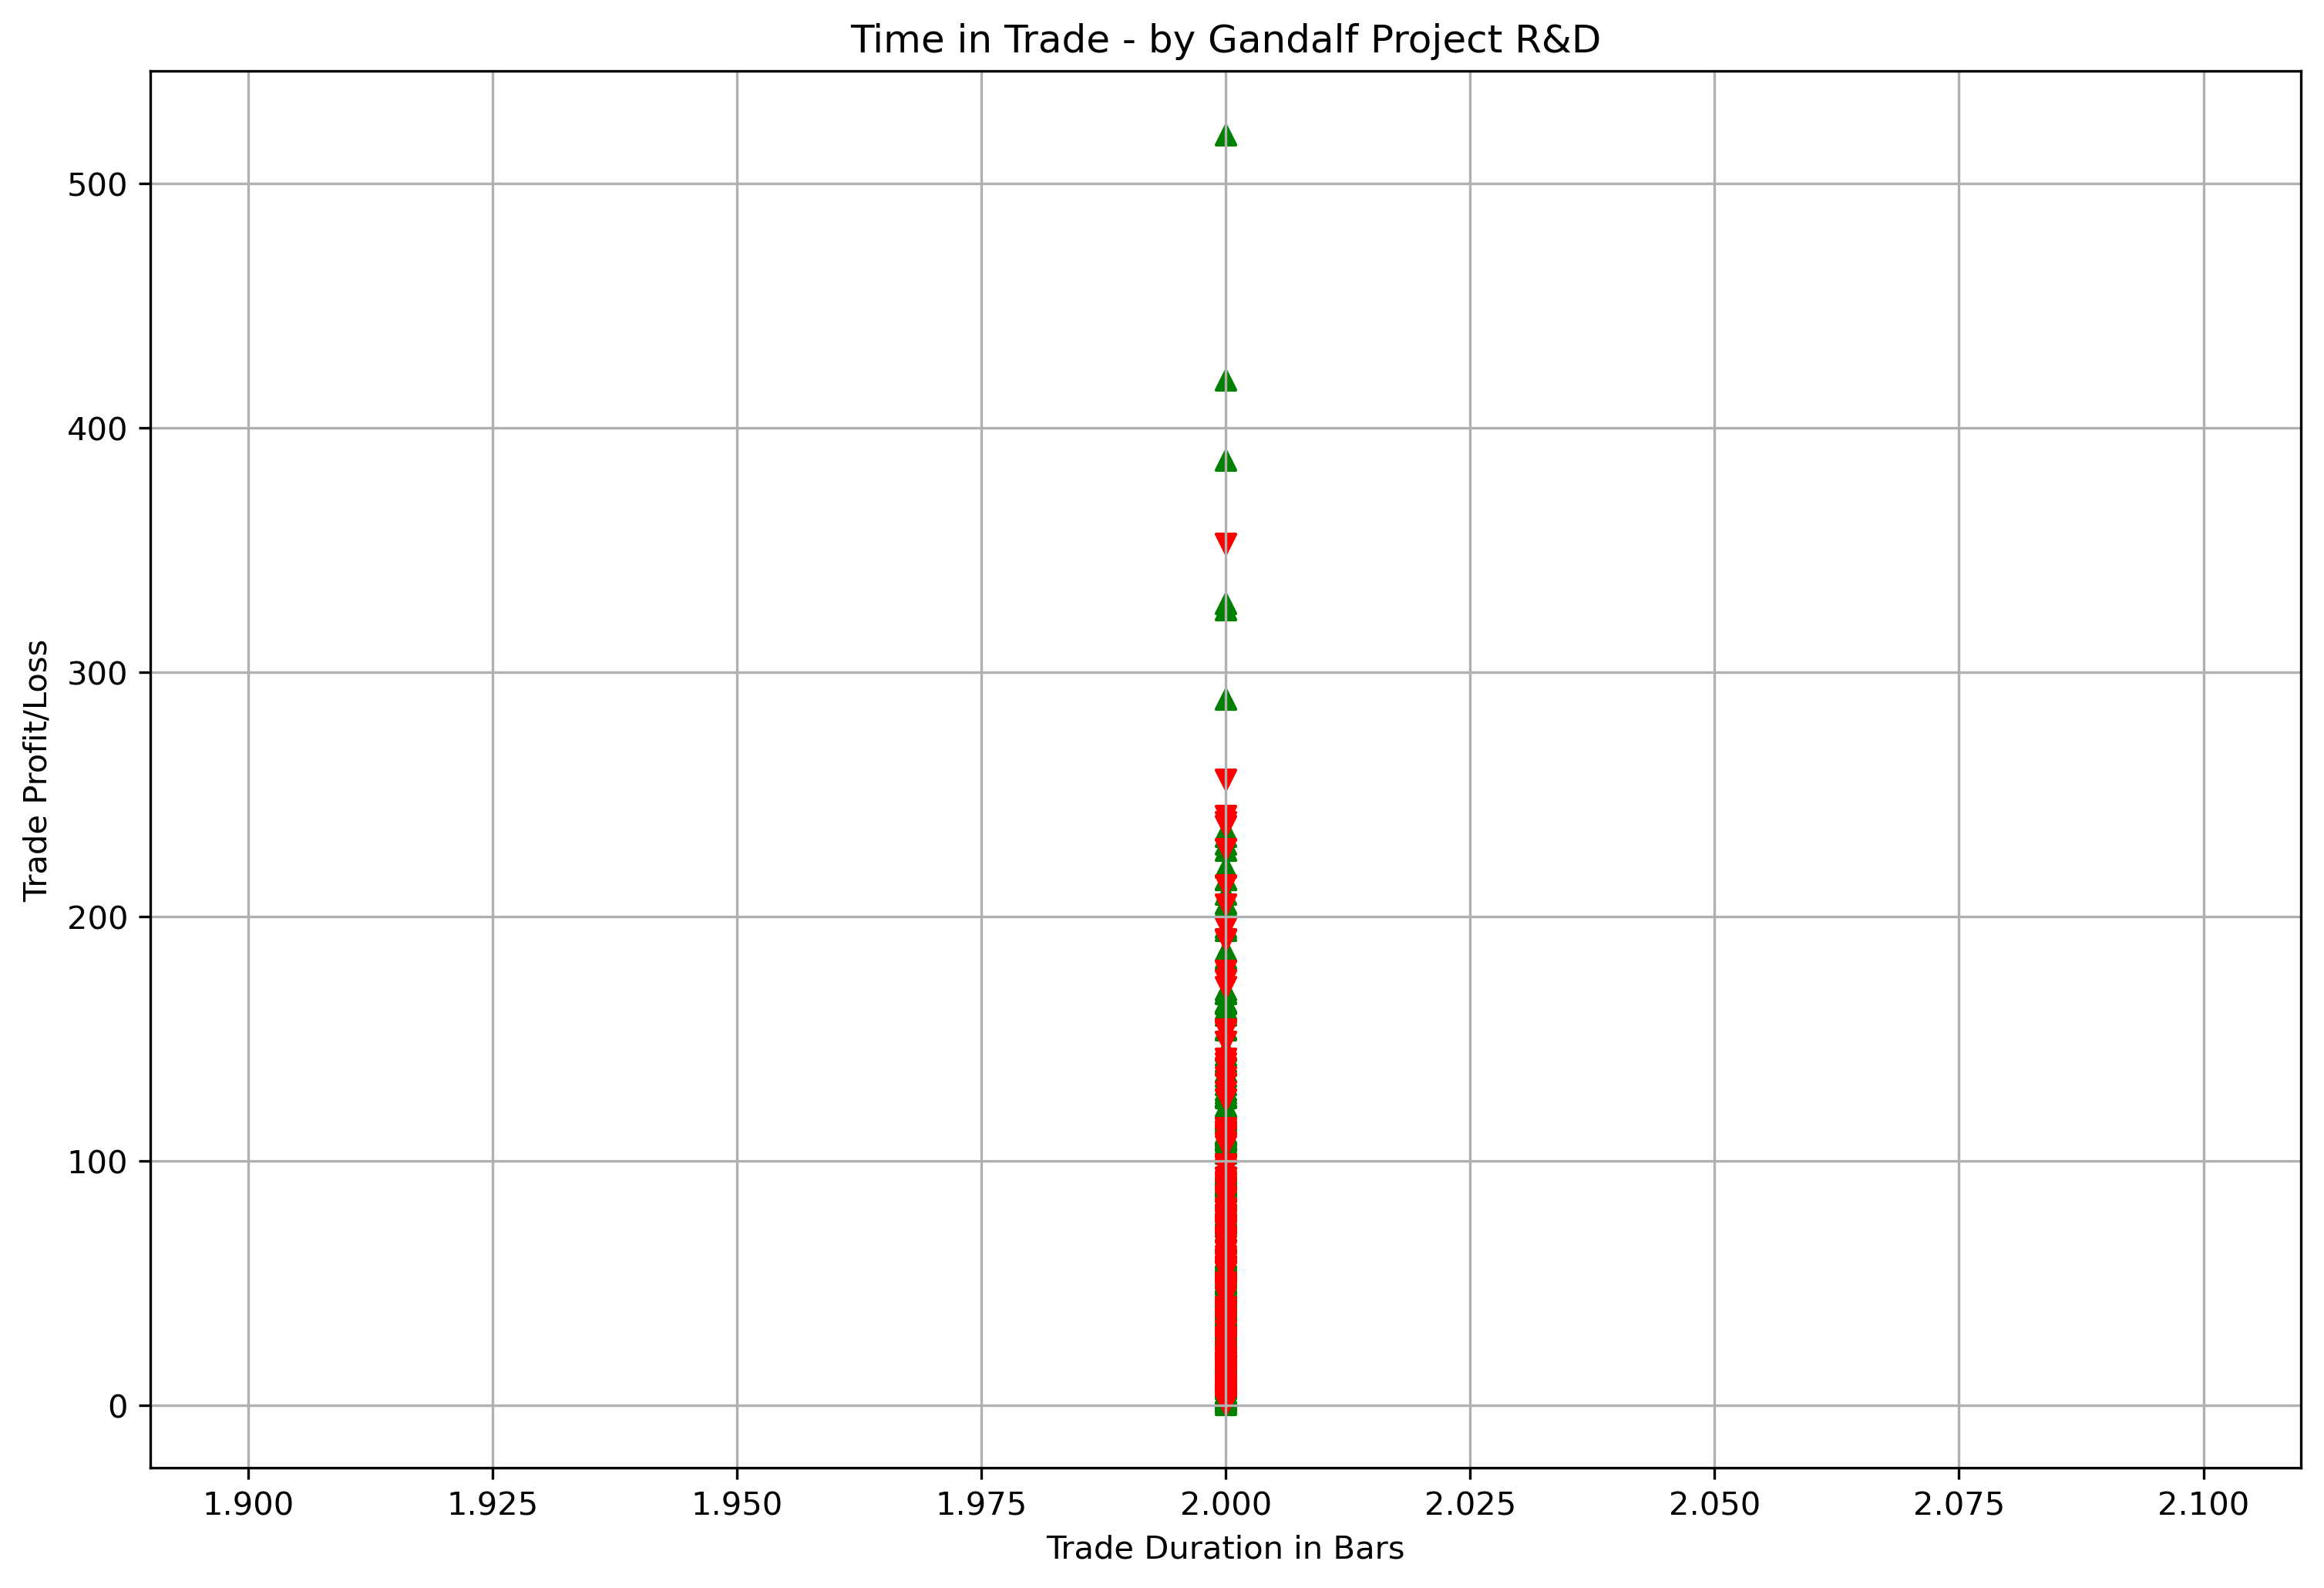

In [90]:
dataset["entry_rule"] = eval(dna_formula(last_dna)) #setups(numba.typed.List(last_dna))

NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = False
CONSECUTIVE_TRADES = True

COSTS_FIXED = COSTS_FIXED
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = TICK
BIGPOINTVALUE = BIGPOINTVALUE
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 100

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = TIME_EXIT  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

enter_level = dataset.high

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable

DIRECTION = DIRECTION

enter_rules = dataset["entry_rule"]

exit_rules = False

tradelist, open_equity, closed_equity, operation_equity = apply_trading_system(dataset.iloc[:], INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
performance_report(dataset, tradelist, closed_equity, open_equity, 100000, 0, MARGIN_PERCENT, False)

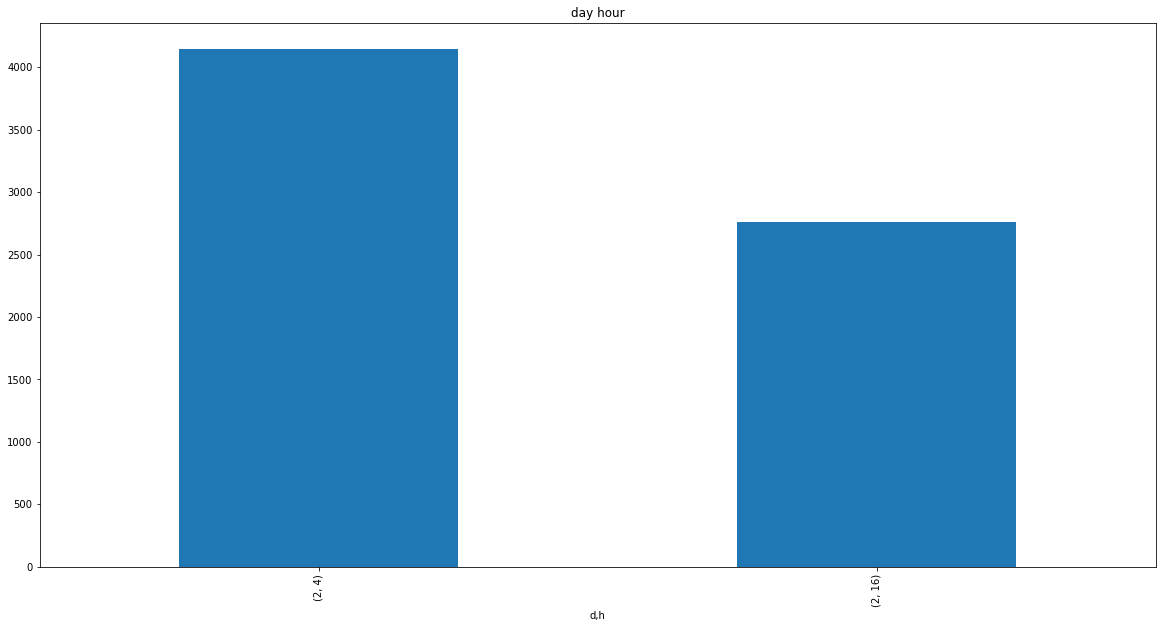

In [91]:

an = tradelist.copy()
an.set_index(["entry_date"],inplace=True)
an["h"]=an.index.hour
an["d"]=an.index.dayofweek
an["d_m"]=an.index.day

an.groupby(["d","h",]).sum().operations.plot.bar(title="day hour",figsize=(20,10))
plt.show()

In [24]:
test=tradelist.operations

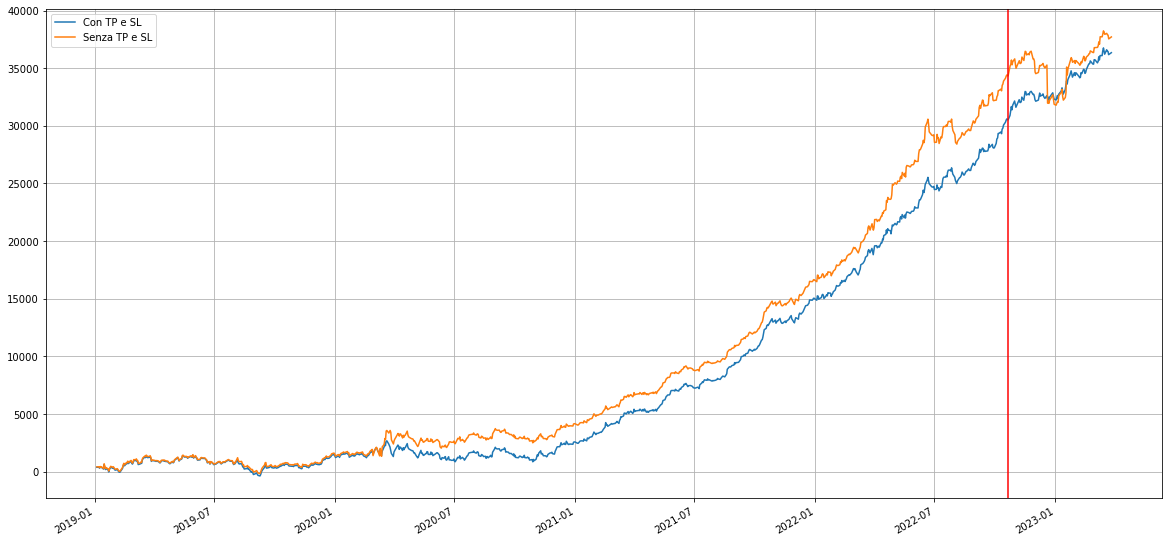

In [26]:
test.cumsum().plot(figsize=(20,10),grid=True,label="Con TP e SL")
tradelist.operations.cumsum().plot(figsize=(20,10),grid=True,label="Senza TP e SL")
plt.axvline(x=OOS_date,color="red")
plt.legend()
plt.show()

In [92]:
DIRECTION

'long'

In [93]:
Long_strategy = tradelist.operations
Long_dna = dna_formula(last_dna)
Long_Exit = TIME_EXIT

In [37]:
Short_strategy = tradelist.operations
Short_dna = dna_formula(last_dna)
Short_Exit = TIME_EXIT

In [38]:
System = pd.concat([Long_strategy,Short_strategy ],axis=1).fillna(0)
System.columns=(["Long","short"])

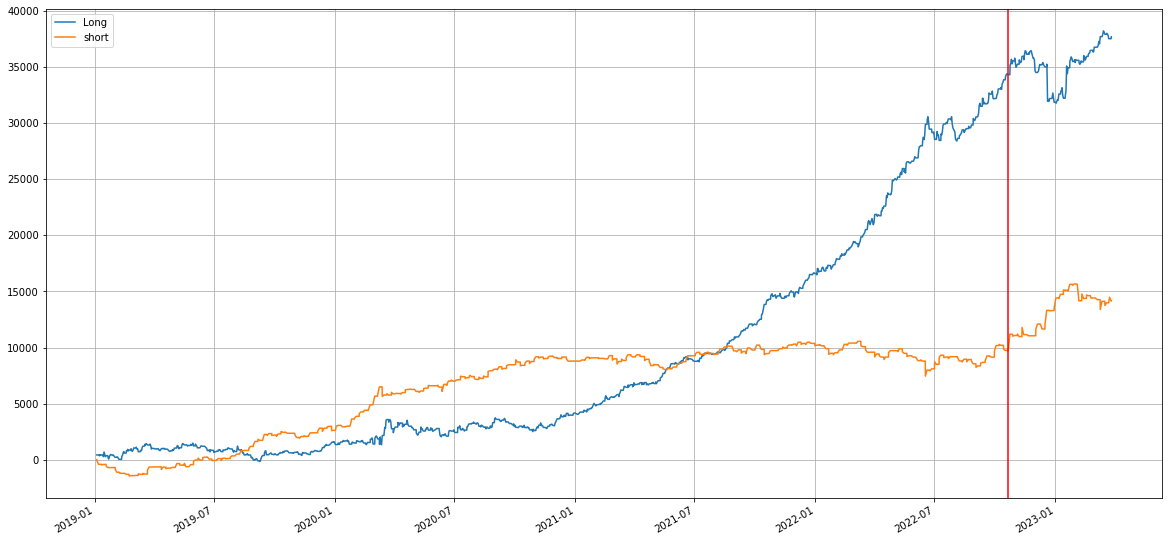

In [39]:
System.cumsum().plot(figsize=(20,10),grid=True)
plt.axvline(x=OOS_date,color="red")

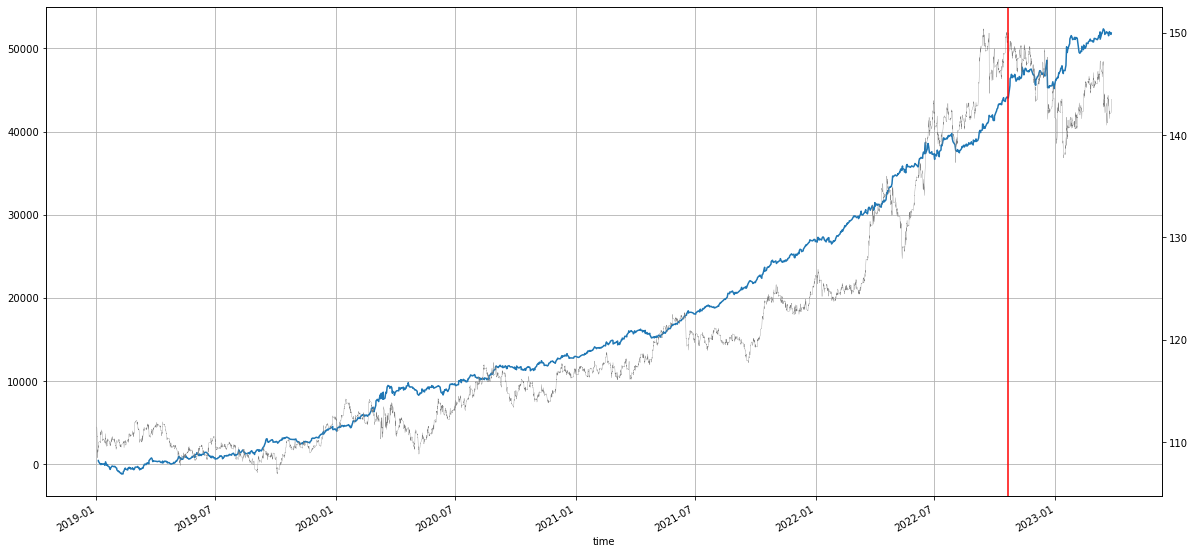

In [45]:
System.sum(axis=1).cumsum().plot(figsize=(20,10),grid=True)
dataset.close.plot(secondary_y=True,color="grey",linewidth=0.3)
plt.axvline(x=OOS_date,color="red")

In [94]:
x=Long_strategy.copy()
x=x[x!=0]

tp=int(x.quantile(0.95))
sl=int(abs(x.quantile(0.05)))  
tp,sl

(183, 140)

In [47]:
x=Short_strategy.copy()
x=x[x!=0]

tp=int(x.quantile(0.95))
sl=int(abs(x.quantile(0.05)))  
tp,sl

(462, 330)

In [305]:
Long_dna

'((dayofweek_condition(dataset,4,8))) & ((hour_condition(dataset,20,7))) & ((hour_condition(dataset,20,3)))'

In [306]:
Short_dna

'((hour_condition(dataset,12,7))) & ((~dayofweek_condition(dataset,2,10))) & ((~dayofweek_condition(dataset,1,10)))'

In [275]:
Long_dna

'((dayofweek_condition(dataset,4))) & ((MACD(dataset,10,-1))) & ((hour_condition(dataset,20)))'

In [276]:
Short_dna

'((~hour_condition(dataset,16))) & ((hour_condition(dataset,12))) & ((MACD(dataset,25,-1)))'

In [284]:
TIME_EXIT

2

In [88]:
def gpdr(operationsIS, operationsOoS, step, tolerance):
    """
     Gandalf Persistence Distribution Ratio (GPDR)
     Versione evoluta: dividiamo i percentili in step blocchi e per ciascuno confrontiamo il valore numerico
     in In Sample ed in Out of Sample. Tolleriamo un degrado tra risultati In Sample ed Out of Sample
     di non oltre la tolerance.
    """
    operationsIS = pd.Series(operationsIS)
    operationsOoS = pd.Series(operationsOoS)
    #step = 0.1
    values = np.arange(0.0, 1.0 + step, step)
    #print(values)
    #print("")

    IS = 0
    OoS = 0
    for i in values:
        if operationsIS.quantile(i) > 0:
            if ((1 - tolerance) * operationsIS.quantile(i)) <= operationsOoS.quantile(i):
                OoS += 1
            else:
                IS += 1
            #print(round(i,2), 
            #      round(operationsIS.quantile(i), 2), 
            #      round((1 - tolerance) * operationsIS.quantile(i), 2),
            #      round(operationsOoS.quantile(i), 2), IS, OoS, )
        if operationsIS.quantile(i) <= 0:
            if ((1 + tolerance) * operationsIS.quantile(i)) <= operationsOoS.quantile(i):
                OoS += 1
            else:
                IS += 1
            #print(round(i,2),
            #      round(operationsIS.quantile(i), 2),
            #      round((1 + tolerance) * operationsIS.quantile(i), 2),
            #      round(operationsOoS.quantile(i), 2), IS, OoS, )
    
    best = round(OoS / len(values) * 100, 2)
    worst = round(IS / len(values) * 100, 2)
    
    #print("")
    #print("Gandalf Persistence Distribution Ratio (GPDR):", round(best / worst,2))
    #print("Gandalf Persistence Distribution Index (GPDI_OOS):", best, "%",)
    #print("Gandalf Persistence Distribution Index (GPDI_IS):", worst, "%")

    if (best == 0) | (worst ==0):
        return 0
    else:
        return round(best / worst,2)

def fast_GSA(dataframe,n_split):
    newdf_split = np.array_split(dataframe, n_split)
    return np.concatenate(newdf_split[0::2]) , np.concatenate(newdf_split[1::2])

In [89]:
newdf = System.sum(axis=1)

gpdr_results = []

n_test=1000

for i in tqdm(np.random.randint(10,100, size=n_test)):
    tradelist_IS , tradelist_OOS = fast_GSA(newdf,i)
    gpdr_results.append(gpdr(tradelist_IS, tradelist_OOS, 0.1, 0.0))

print ("Gpdr medio :",round(np.mean(gpdr_results),2))
print ("Gpdr % su n°",n_test,"test :",(len([e for e in gpdr_results if e >= 1])*100)/n_test,"%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Gpdr medio : 1.83
Gpdr % su n° 1000 test : 38.3 %
